In [34]:
# Imports
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
import mglearn
import glob
import scipy.io as sio
from scipy import stats
from scipy.signal import hilbert
from neurodsp import spectral
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
import statsmodels.api as sm



# imports own modules
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')
from module_load_data import get_signal
import module_pac_functions as pacf


In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('data_dict.npy',  allow_pickle=True).item()
features_df = np.load('features_df.npy', allow_pickle=True).item()

In [3]:
# get absolute symmetry values
for key in datastruct:
    
    # get absolute assymetric measures by calculating distance from 0.5
    features_df[key]['rdsym_abs'] = abs(features_df[key]['rdsym'] -.5)
    features_df[key]['ptsym_abs'] = abs(features_df[key]['ptsym'] -.5)

# 1. Descriptives

In [53]:
print('number of analyzed recordings for humans:')
print(len(features_df['human']))
print('number of analyzed recordings for monkeys:')
print(len(features_df['monkey']))

print('average rho value of sig. PAC recordings in humans:')
print(features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].mean())

print('average rho value of sig. PAC recordings in monkeys:')
print(features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].mean())

number of analyzed recordings for humans:
1110
number of analyzed recordings for monkeys:
3072
average rho value of sig. PAC recordings in humans:
0.02541508259141956
average rho value of sig. PAC recordings in monkeys:
0.03408361292945871


In [52]:
features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].mean()

0.02541508259141956

In [49]:
features_df['human'][features_df['human']['pac_rhos'>.1]]


TypeError: '>' not supported between instances of 'str' and 'float'

# 2. Descriptive characteristics of extracted features


Text(0.5, 1, 'Average correlation between features across datasets')

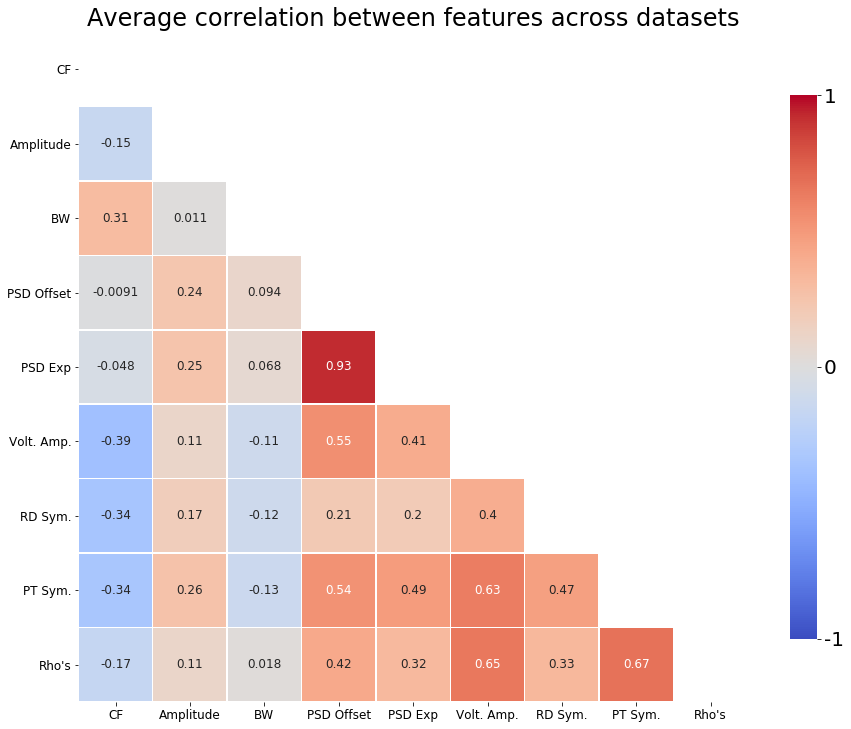

In [56]:
feature_names = ['CF', 'Amplitude', 'BW', 'PSD Offset', 'PSD Exp',
                 'Volt. Amp.', 'RD Sym.', 'PT Sym.', 'Rho\'s']

corr_mat_human = features_df['human'][['CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy().corr()
corr_mat_monkey = features_df['monkey'][['CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy().corr()
# corr_mat_rat = features_df['rat'][['CF', 'Amp', 'BW', 'offset', 'exp',
#                                 'volt_amp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy().corr()

# corr_average = (corr_mat_human + corr_mat_monkey + corr_mat_rat) / 3

corr_average = (corr_mat_human + corr_mat_monkey) / 2

mask = np.zeros_like(corr_average, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_average,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [-1, 0, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(feature_names, rotation = 0, size=12)
ax.set_xticklabels(feature_names, size=12)

heatmap.figure.axes[-1].set_yticklabels(['-1', '0', '1'],size=20)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title('Average correlation between features across datasets', size=24)

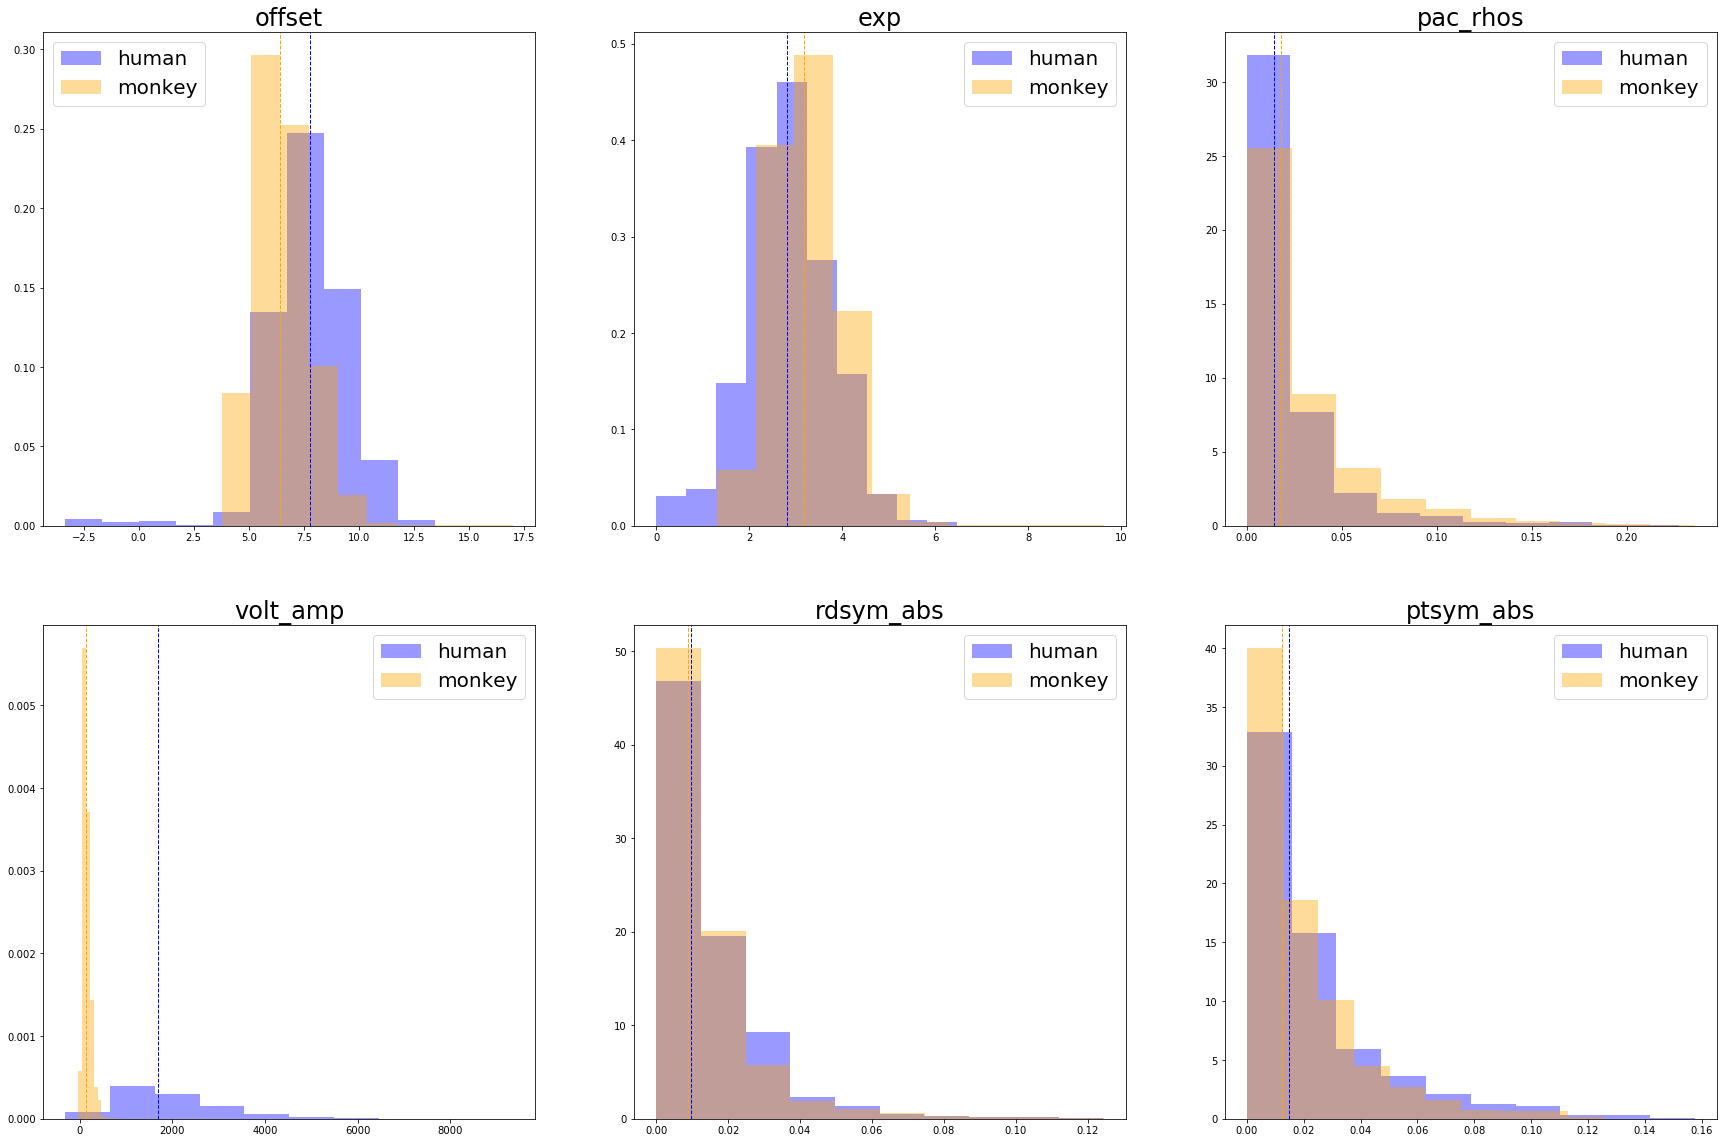

In [5]:
hist_list = ['offset', 'exp', 'pac_rhos', 
       'volt_amp', 'rdsym_abs', 'ptsym_abs']


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(30,20))
for ii in range(len(hist_list)): 

    # subplots 4x3
    plt.subplot(2,3,ii+1)

    
    plt.hist(features_df['human'][hist_list[ii]].dropna(), color='blue', label='human', **kwargs)
    plt.hist(features_df['monkey'][hist_list[ii]].dropna(), color='orange', label='monkey', **kwargs)
#     plt.hist(features_df['rat'][hist_list[ii]].dropna(), color='green', label='rat', **kwargs)

    
    plt.axvline(np.nanmedian(features_df['human'][hist_list[ii]]), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(features_df['monkey'][hist_list[ii]]), color='orange', linestyle='dashed', linewidth=1)
#     plt.axvline(np.nanmedian(features_df['rat'][hist_list[ii]]), color='green', linestyle='dashed', linewidth=1)
    plt.legend(fontsize=20)
    plt.title(hist_list[ii], size=24)

# 3. Measured PAC 

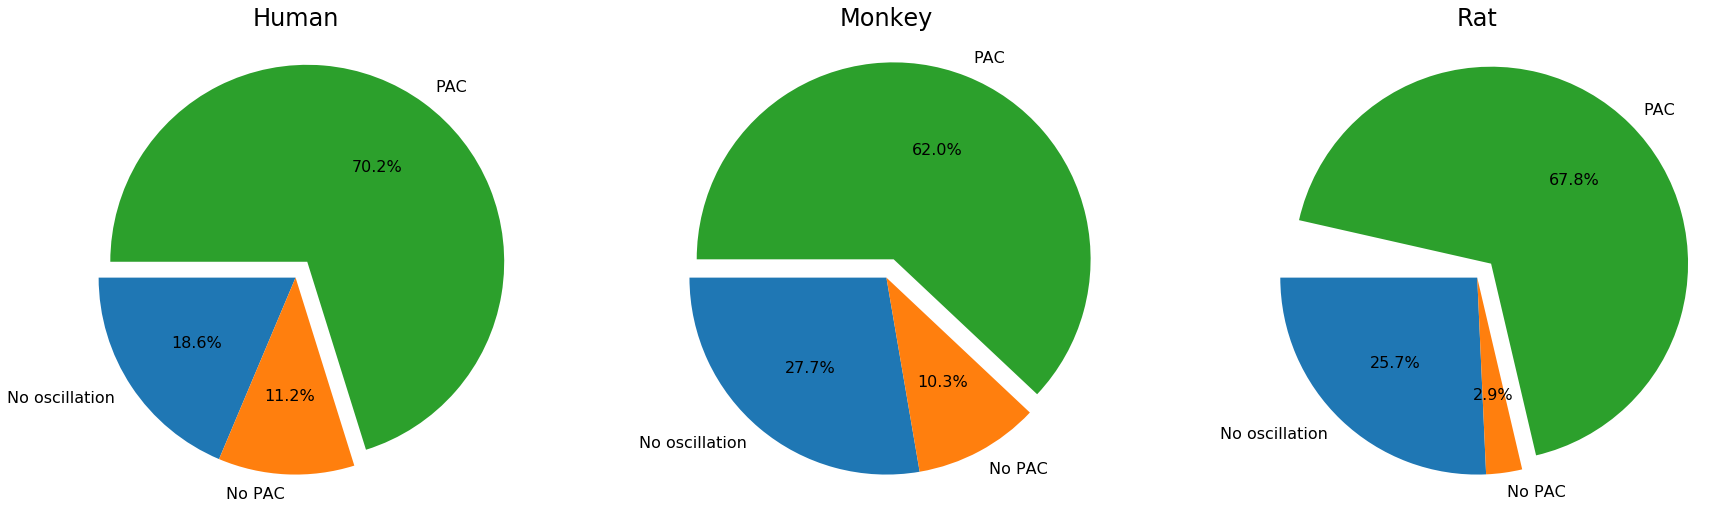

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation', 'No PAC', 'PAC'
sizes = [[1 - (features_df['human']['CF'].count()/ len(features_df['human'])),
         len(features_df['human'][features_df['human']['pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (features_df['monkey']['CF'].count()/ len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (features_df['rat']['CF'].count()/ len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)

# 3.1 Stacked bar instead of pie chart

18.64864864864865
11.17117117117117
70.18018018018019
27.701822916666668
10.286458333333332
62.01171875


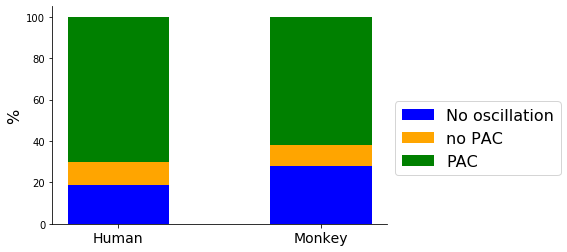

In [11]:
fig, ax = plt.subplots()
idx = np.arange(2)
count = 0
width = 0.5
for key in datastruct: 
    
    if count < 2:

        no_osc =  len(features_df[key][features_df[key]['pac_presence'] == np.int64]) / len(features_df[key]) * 100
        no_pac =  len(features_df[key][features_df[key]['pac_presence']==0]) / len(features_df[key]) * 100
        yes_pac = len(features_df[key][features_df[key]['pac_presence']==1]) / len(features_df[key]) * 100
        
        print(no_osc)
        print(no_pac)
        print(yes_pac)
        

        p1 = plt.bar(count+0.5, no_osc, width, color='blue')
        p2 = plt.bar(count+0.5, no_pac, width,
                     bottom=no_osc, color='orange')
        p3 = plt.bar(count+0.5, yes_pac, width,
                     bottom=no_osc + no_pac, color='green')    

        count = count + 1
plt.ylabel('%', size=16)
#plt.title('Signals with PAC (%)', size=16)
plt.xticks(idx +.5, ('Human', 'Monkey'), size=14)
plt.legend(['No oscillation', 'no PAC', 'PAC'], bbox_to_anchor=(1, .6), fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()    

# 4. Machine learning - Distinguishing true and waveform shaped PAC

2 components explaining: 58.70745416594395 %


<Figure size 360x720 with 0 Axes>

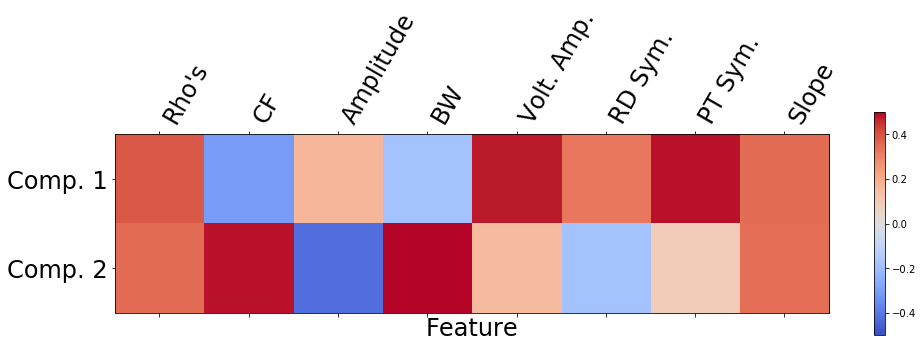

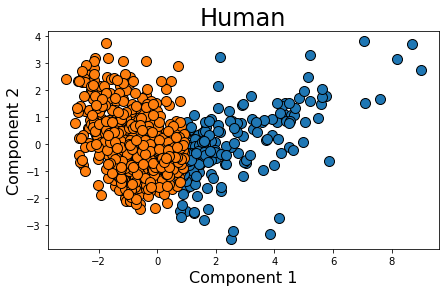

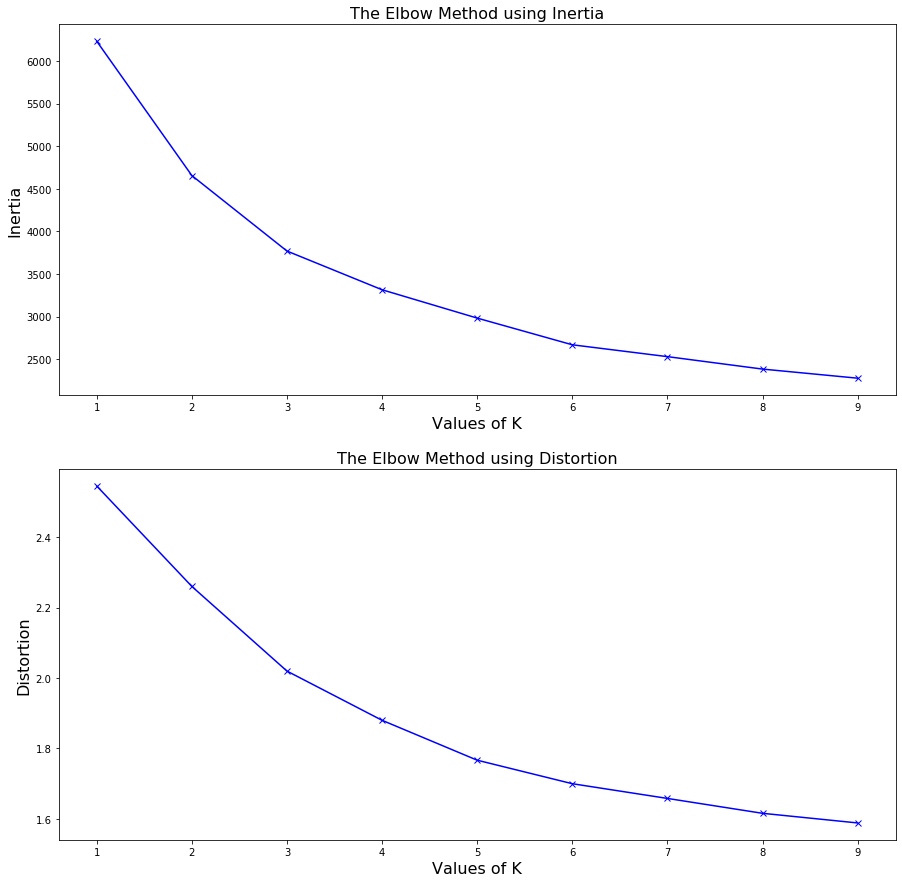

2 components explaining: 59.20190496867367 %


<Figure size 360x720 with 0 Axes>

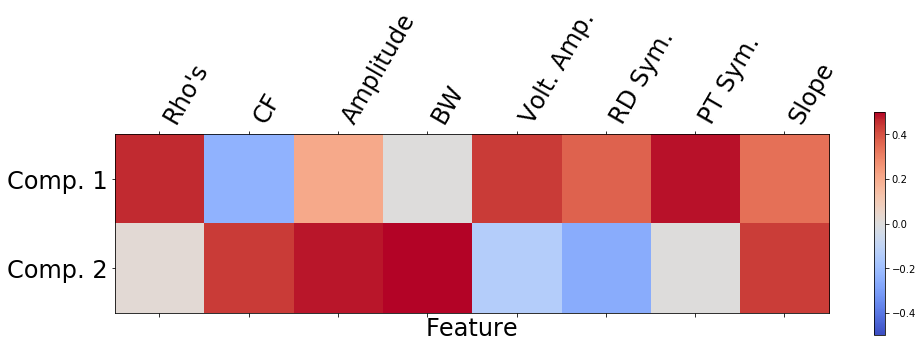

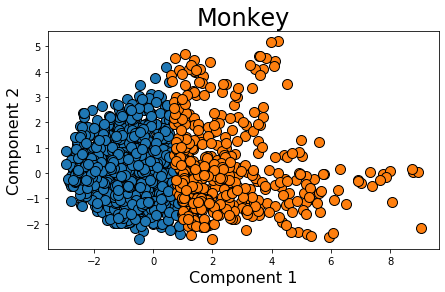

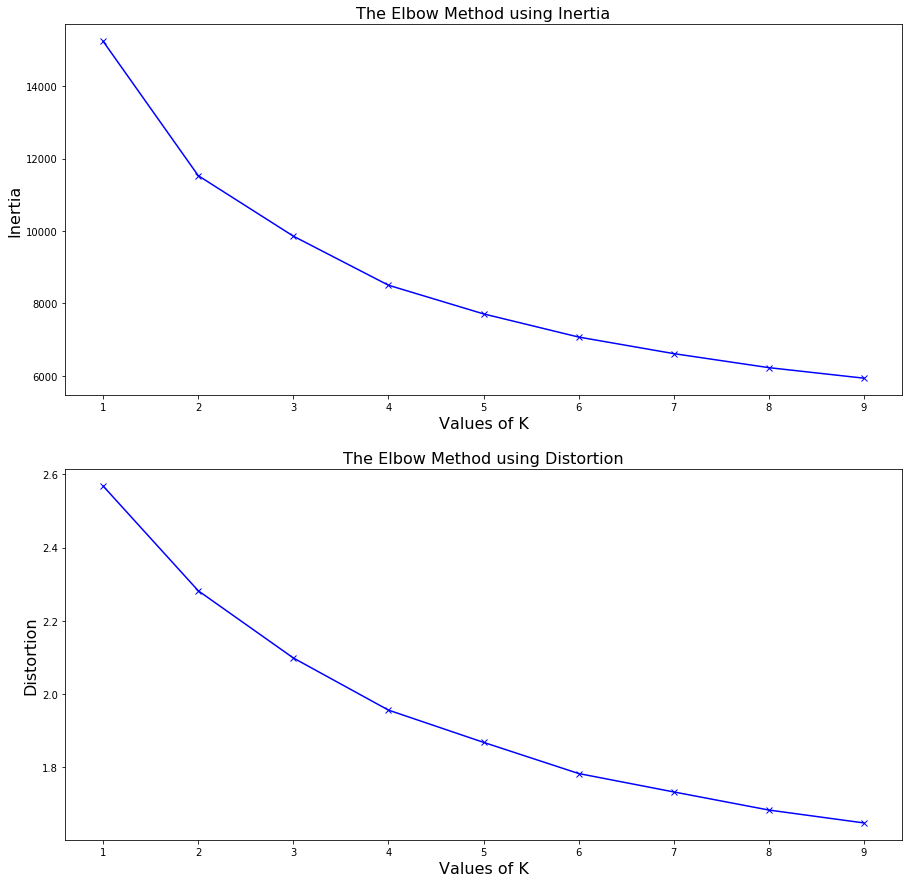

2 components explaining: 53.59217845022398 %


<Figure size 360x720 with 0 Axes>

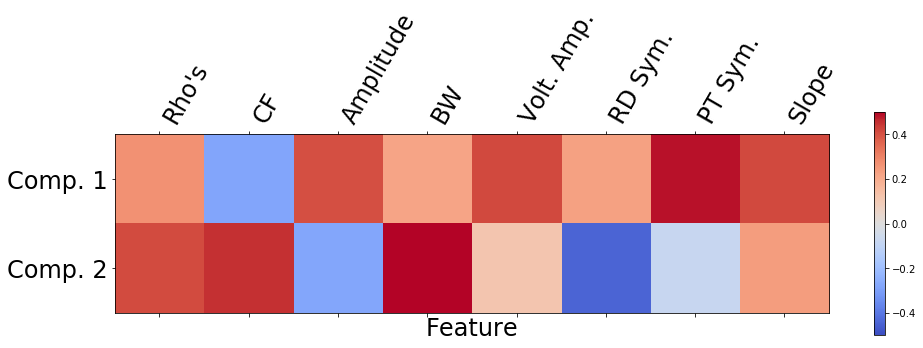

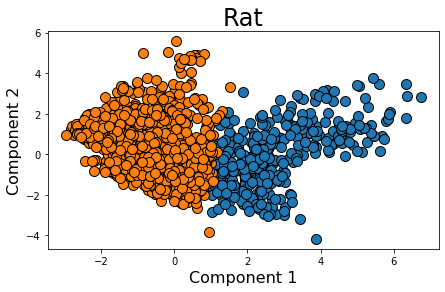

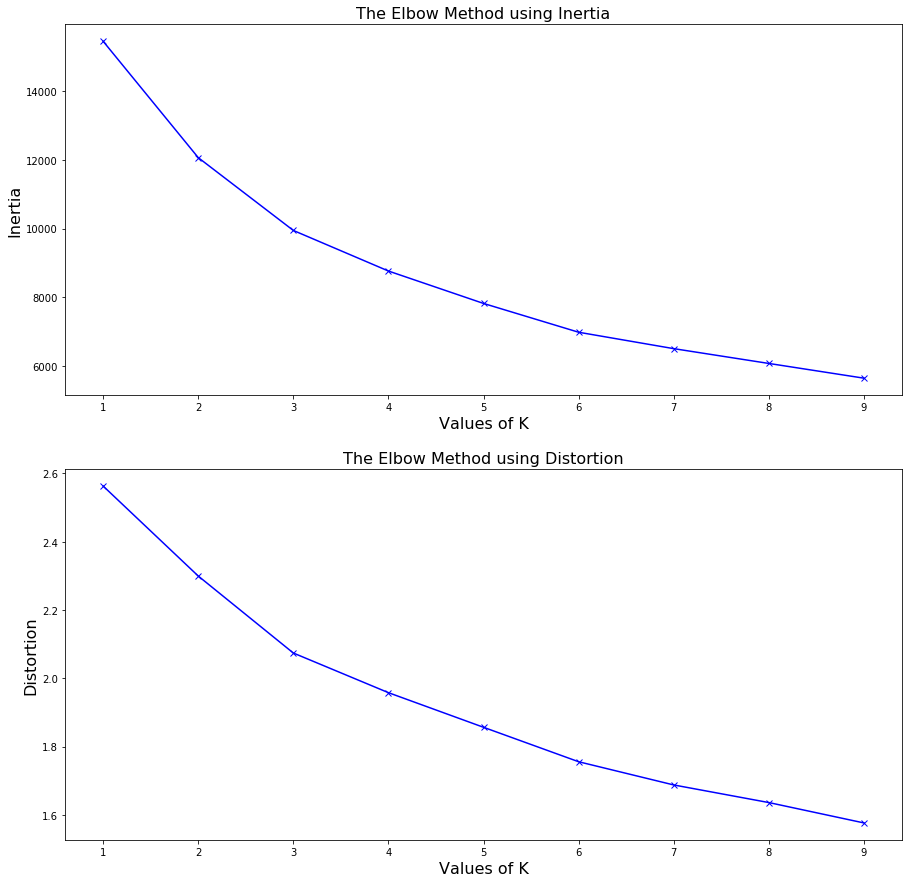

In [36]:
counter = 0
name_list = ['Human', 'Monkey', 'Rat']


for key in datastruct:

    # change shape of the aperiodic slope measurement
    offset = np.reshape(features_df[key][['offset']].copy(), [len(features_df[key]['offset']), 1])
    exp = np.reshape(features_df[key][['exp']].copy(), [len(features_df[key]['exp']), 1])

    # standard scale into 1 variable
    scaler = StandardScaler()
    slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

    # write new feature to dataframe
    features_df[key]['slope'] = slope
        
    # then only select the channels that have sig. PAC after resampling
    features_df_pac = features_df[key][features_df[key]['pac_presence']==1]

    # stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
    cluster_features = np.hstack((
                       features_df_pac[['pac_rhos']].copy(), features_df_pac[['CF']].copy(), 
                       features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                       features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym_abs']].copy(), 
                       features_df_pac[['ptsym_abs']].copy(), features_df_pac[['slope']].copy()))

    # Scale all data 
    scaler = StandardScaler()
    scaler.fit(cluster_features)
    X_scaled = scaler.transform(cluster_features)

    # Use K-Means to cluster into two groups
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_scaled);

    # Use PCA to create two components
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    print('2 components explaining: '+ str(pca.explained_variance_ratio_.sum() * 100) + ' %')

    # Create list with feature names for visualization 
    feature_list = ['Rho\'s', 'CF', 'Amplitude', 'BW', 'Volt. Amp.', 'RD Sym.', 'PT Sym.', 'Slope' ]

    plt.figure(figsize=(5,10))


    # Which features drive both components?
    plt.matshow(pca.components_, cmap='coolwarm');
    plt.yticks([0, 1], ["Comp. 1", "Comp. 2"], size=24);
    plt.colorbar();
    plt.clim(-.5, .5)
    plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left', size=24);
    plt.xlabel("Feature", size=24);
    # plt.ylabel("Principal components", size=16);
    plt.show()

    # visualize on PCA  
    plt.figure(figsize=(7,4))
    mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
    plt.title(name_list[counter], size=24)
    plt.xlabel("Component 1", size=16)
    plt.ylabel("Component 2", size=16)
    plt.show()

    
    # elbow method to see best amount of clusters
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,10) 

    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
        kmeanModel.fit(X_scaled)     

        distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                          'euclidean'),axis=1)) / X_scaled.shape[0]) 
        inertias.append(kmeanModel.inertia_) 

        mapping1[k] = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                     'euclidean'),axis=1)) / X_scaled.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 

    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K', size=16) 
    plt.ylabel('Inertia', size=16) 
    plt.title('The Elbow Method using Inertia', size=16) 

    plt.subplot(2,1,2)
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K', size=16) 
    plt.ylabel('Distortion', size=16) 
    plt.title('The Elbow Method using Distortion', size=16) 
    plt.show()
    
    counter = counter + 1

# Visualization clusters



2 components explaining: 58.70745416594401 %
component 1 explaining: 41.074901618129864 %
component 2 explaining: 17.632552547814146 %


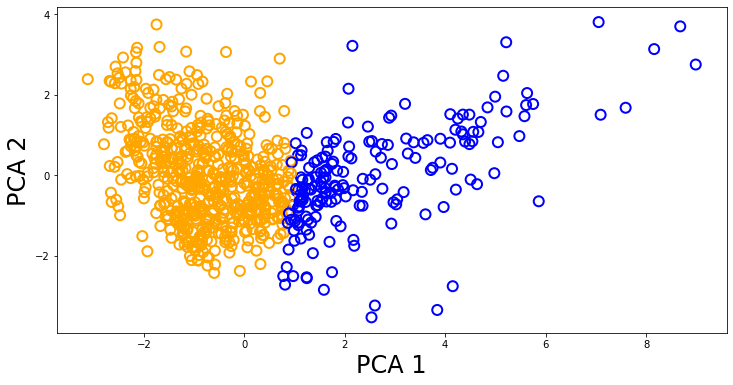

2 components explaining: 59.20190496867364 %
component 1 explaining: 39.76354695148979 %
component 2 explaining: 19.438358017183845 %


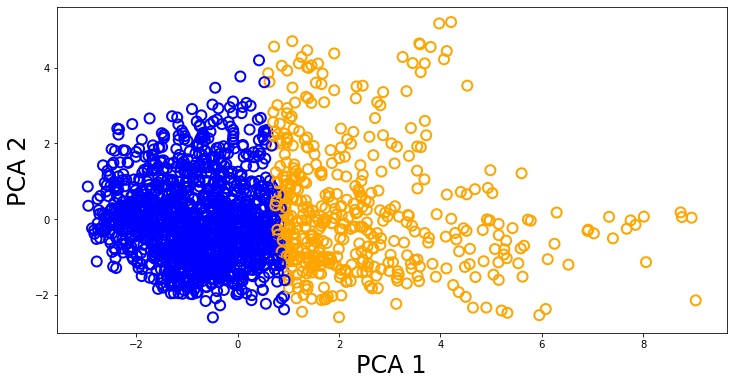

In [37]:
counter = 0
name_list = ['Human', 'Monkey', 'Rat']


for key in datastruct:

    # change shape of the aperiodic slope measurement
    offset = np.reshape(features_df[key][['offset']].copy(), [len(features_df[key]['offset']), 1])
    exp = np.reshape(features_df[key][['exp']].copy(), [len(features_df[key]['exp']), 1])

    # standard scale into 1 variable
    scaler = StandardScaler()
    slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

    # write new feature to dataframe
    features_df[key]['slope'] = slope
        
    # then only select the channels that have sig. PAC after resampling
    features_df_pac = features_df[key][features_df[key]['pac_presence']==1]

    # stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
    cluster_features = np.hstack((
                       features_df_pac[['pac_rhos']].copy(), features_df_pac[['CF']].copy(), 
                       features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                       features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym_abs']].copy(), 
                       features_df_pac[['ptsym_abs']].copy(), features_df_pac[['slope']].copy()))

    # Scale all data 
    scaler = StandardScaler()
    scaler.fit(cluster_features)
    X_scaled = scaler.transform(cluster_features)

    # Use K-Means to cluster into two groups
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_scaled);

    # Use PCA to create two components
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    print('2 components explaining: '+ str(pca.explained_variance_ratio_.sum() * 100) + ' %')
    print('component 1 explaining: '+ str(pca.explained_variance_ratio_[0] * 100) + ' %')
    print('component 2 explaining: '+ str(pca.explained_variance_ratio_[1] * 100) + ' %')


    colormap = np.array(['blue', 'orange'])

    # visualize on PCA   
    plt.figure(figsize=(12,6))
    plt.scatter(X_pca[:, 0], X_pca[:,1], s=100,  marker ='o', facecolors='none', edgecolors=colormap[kmeans.labels_],linewidths=2)
    plt.xlabel("PCA 1", size=24)
    plt.yticks([-2, 0, 2, 4])
    plt.ylabel("PCA 2", size=24)
    plt.show()
    
    counter = counter + 1
    
    if counter == 2:
        break

# Visualization contribution to PCA

2 components explaining: 58.70745416594404 %
2 components explaining: 59.2019049686736 %


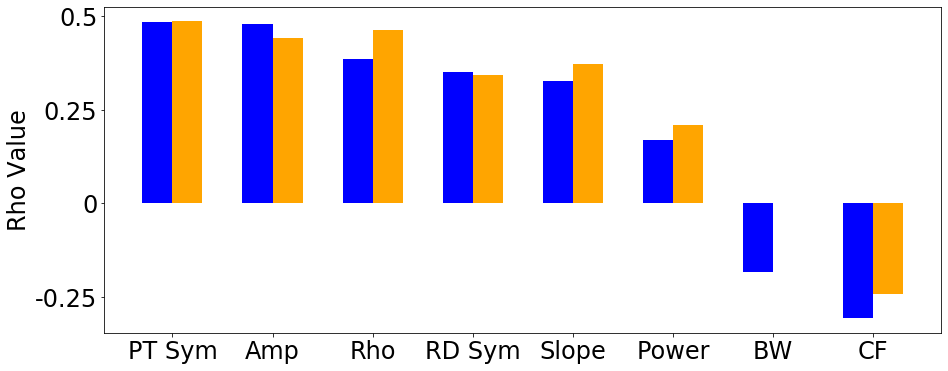

[Text(0, 0, '-0.25'), Text(0, 0, '0'), Text(0, 0, '0.25'), Text(0, 0, '0.5')]

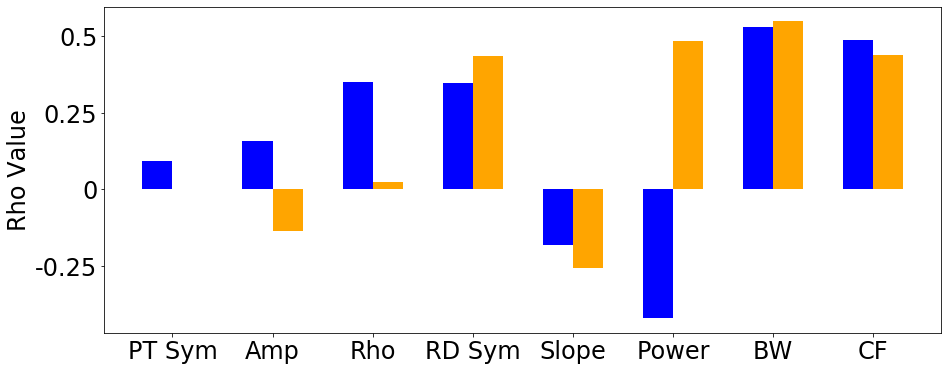

In [38]:
counter = 0
name_list = ['Human', 'Monkey', 'Rat']


for key in datastruct:

    # change shape of the aperiodic slope measurement
    offset = np.reshape(features_df[key][['offset']].copy(), [len(features_df[key]['offset']), 1])
    exp = np.reshape(features_df[key][['exp']].copy(), [len(features_df[key]['exp']), 1])

    # standard scale into 1 variable
    scaler = StandardScaler()
    slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

    # write new feature to dataframe
    features_df[key]['slope'] = slope
        
    # then only select the channels that have sig. PAC after resampling
    features_df_pac = features_df[key][features_df[key]['pac_presence']==1]

    # stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
    cluster_features = np.hstack((
                    features_df_pac[['ptsym_abs']].copy(),
                    features_df_pac[['volt_amp']].copy(),
                    features_df_pac[['pac_rhos']].copy(),
                    features_df_pac[['slope']].copy(),
                    features_df_pac[['rdsym_abs']].copy(), 
                    features_df_pac[['Amp']].copy(),
                    features_df_pac[['BW']].copy(),
                    features_df_pac[['CF']].copy())) 
         

    # Scale all data 
    scaler = StandardScaler()
    scaler.fit(cluster_features)
    X_scaled = scaler.transform(cluster_features)

    # Use K-Means to cluster into two groups
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_scaled);

    # Use PCA to create two components
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    print('2 components explaining: '+ str(pca.explained_variance_ratio_.sum() * 100) + ' %')

    # Create list with feature names for visualization 
    feature_list = ['Rho\'s', 'CF', 'Amplitude', 'BW', 'Volt. Amp.', 'RD Sym.', 'PT Sym.', 'Slope' ]

    
    if key == 'human':
        
        human_pca1 = pca.components_[0]
        human_pca2 = pca.components_[1]

    if key == 'monkey':
        
        monkey_pca1 = pca.components_[0]
        monkey_pca2 = pca.components_[1]
        
#     plt.yticks([0, 1], ["Comp. 1", "Comp. 2"], size=24);
#     plt.colorbar();
#     plt.clim(-.5, .5)
#     plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left', size=24);
#     plt.xlabel("Feature", size=24);
    # plt.ylabel("Principal components", size=16);
    plt.show()
    
    counter = counter + 1
    if counter == 2:
        break
        
feature_list = ['PT Sym', 'Amp', 'Rho', 'RD Sym', 'Slope', 'Power', 'BW', 'CF']


x = np.arange(len(feature_list))  # the label locations
width = 0.3  # the width of the bars

# PCA 1 
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width/2, human_pca1, width, color='blue')
rects2 = ax.bar(x + width/2, monkey_pca1, width, color = 'orange')

#ax.set_title('Correlations between component 1 and features', size=24)
ax.set_ylabel('Rho Value', size=24)
ax.set_xticks(x)
ax.set_yticks([-.25, 0, .25, .5])
ax.set_xticklabels(feature_list, fontsize=24)
ax.set_yticklabels([-.25, 0, .25, .5], fontsize=24)
plt.show()

# PCA 2 
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width/2, human_pca2, width, color='blue')
rects2 = ax.bar(x + width/2, monkey_pca2, width, color = 'orange')

#ax.set_title('Correlation between component 2 and features', size=24)
ax.set_ylabel('Rho Value', size=24)
ax.set_xticks(x)
ax.set_yticks([-.25, 0, .25, .5])
ax.set_xticklabels(feature_list, fontsize=24)
ax.set_yticklabels([-.25, 0, .25, .5], fontsize=24)

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


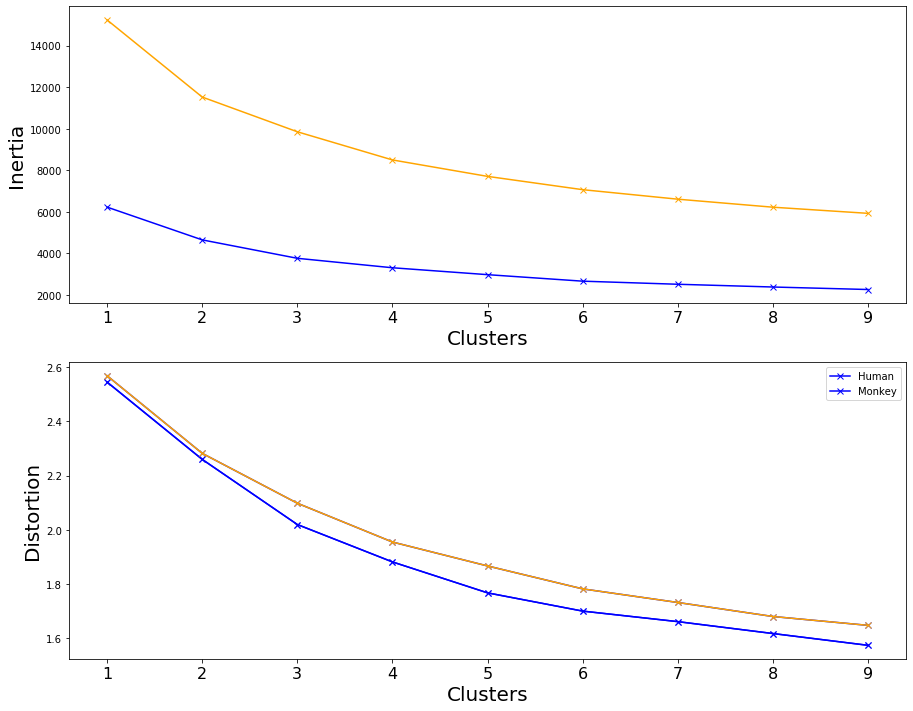

In [39]:
name_list = ['Human', 'Monkey', 'Rat']
color_name = ['blue', 'orange', 'green']
counter =  0 
plt.figure(figsize=(15,12))

for key in datastruct:
    
    # change shape of the aperiodic slope measurement
    offset = np.reshape(features_df[key][['offset']].copy(), [len(features_df[key]['offset']), 1])
    exp = np.reshape(features_df[key][['exp']].copy(), [len(features_df[key]['exp']), 1])

    # standard scale into 1 variable
    scaler = StandardScaler()
    slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

    # write new feature to dataframe
    features_df[key]['slope'] = slope
        
    # then only select the channels that have sig. PAC after resampling
    features_df_pac = features_df[key][features_df[key]['pac_presence']==1]

    # stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
    cluster_features = np.hstack((
                       features_df_pac[['pac_rhos']].copy(), features_df_pac[['CF']].copy(), 
                       features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                       features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym_abs']].copy(), 
                       features_df_pac[['ptsym_abs']].copy(), features_df_pac[['slope']].copy()))

    # Scale all data 
    scaler = StandardScaler()
    scaler.fit(cluster_features)
    X_scaled = scaler.transform(cluster_features)
    
    # elbow method to see best amount of clusters
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,10) 

    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
        kmeanModel.fit(X_scaled)     

        distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                          'euclidean'),axis=1)) / X_scaled.shape[0]) 
        inertias.append(kmeanModel.inertia_) 

        mapping1[k] = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                     'euclidean'),axis=1)) / X_scaled.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 
        
    
    plt.subplot(2,1,1)
    plt.plot(K, inertias, 'x-', color=color_name[counter]) 
    plt.xlabel('Clusters', size=20) 
    plt.ylabel('Inertia', size=20) 
    plt.xticks(size=16)
    #plt.title('The Elbow Method using Inertia', size=16) 

    plt.subplot(2,1,2)
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Clusters', size=20) 
    plt.ylabel('Distortion', size=20)
    plt.xticks(size=16)
    #plt.title('The Elbow Method using Distortion', size=16) 
    plt.plot(K, distortions, 'x-', color=color_name[counter]) 
    plt.legend(['Human', 'Monkey'])
    
    counter = counter + 1
    
    if counter == 2:
        break




# 5. Linear regressions - Effect of features on Rho Value

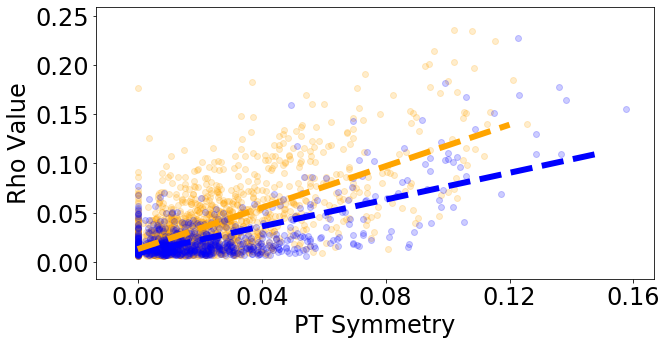

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     638.1
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          2.96e-103
Time:                        14:32:15   Log-Likelihood:                 1949.9
No. Observations:                 779   AIC:                            -3896.
Df Residuals:                     777   BIC:                            -3886.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.001      8.836      0.0

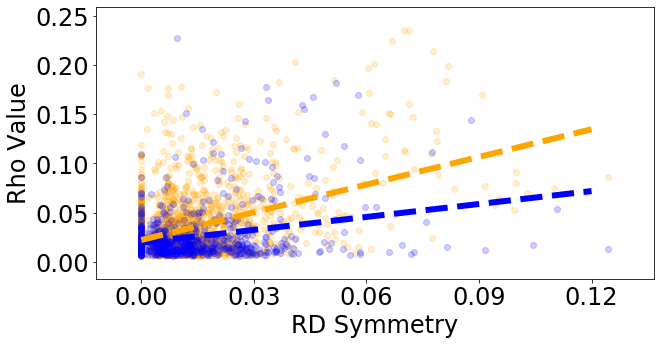

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     54.29
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           4.42e-13
Time:                        14:32:15   Log-Likelihood:                 1742.7
No. Observations:                 779   AIC:                            -3481.
Df Residuals:                     777   BIC:                            -3472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.001     15.359      0.0

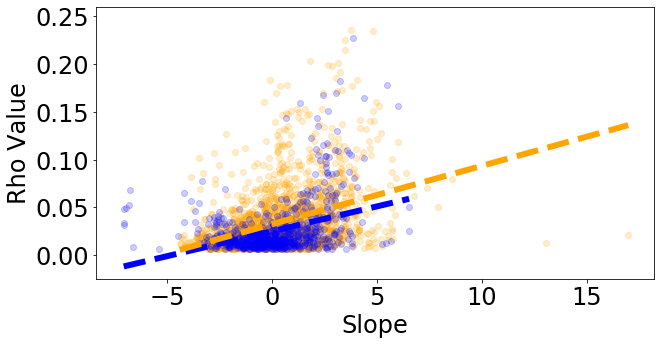

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.69e-26
Time:                        14:32:16   Log-Likelihood:                 1772.8
No. Observations:                 779   AIC:                            -3542.
Df Residuals:                     777   BIC:                            -3532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0250      0.001     27.971      0.0

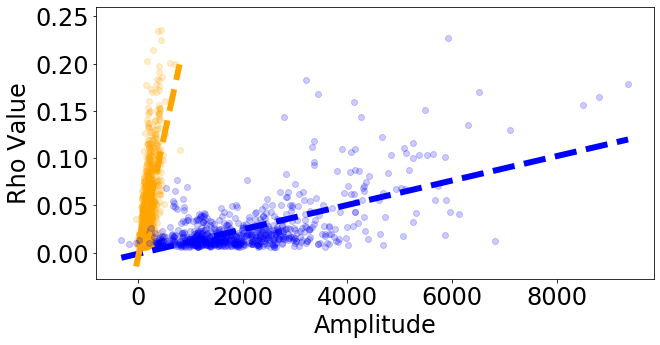

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     464.8
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           3.65e-81
Time:                        14:32:17   Log-Likelihood:                 1899.0
No. Observations:                 779   AIC:                            -3794.
Df Residuals:                     777   BIC:                            -3785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.853      0.3

In [48]:
# reshape pac_rhos
pac_rhos_human = features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_monkey = features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'ptsym_abs', 'rdsym_abs']
"""

feature = ['ptsym_abs', 'rdsym_abs', 'slope', 'volt_amp']
feature_name = ['PT Symmetry', 'RD Symmetry', 'Slope', 'Amplitude']
ticklist = [[0, 0.04, 0.08, 0.12, 0.16],[0, 0.03, 0.06, 0.09, 0.12],[-5, 0, 5, 10, 15], [0, 2000, 4000, 6000, 8000]]

for ii in range(len(feature)):

    # reshape other feature
    feature_human = features_df['human'][features_df['human']['pac_presence']==1][feature[ii]].values.reshape(-1,1)
    feature_monkey = features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]].values.reshape(-1,1)
#     feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]].values.reshape(-1,1)

    plt.figure(figsize=(10,5))

    
#     # Rat scatter
#     plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]],
#                 features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
#                color='green', alpha =.3, label='Rat')
    
    # Monkey scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
               color='orange', alpha =.2, label='Monkey')
    
    # Human scatter
    plt.scatter(features_df['human'][features_df['human']['pac_presence']==1][feature[ii]],
                features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'],
               color='blue', alpha =.2, label='Human')


    # Human regression
    reg1 = linear_model.LinearRegression()
    reg1.fit(feature_human, pac_rhos_human)
    xs = np.arange(min(feature_human), max(feature_human),0.01)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=6, alpha=1)

    # Monkey regression
    reg2 = linear_model.LinearRegression()
    reg2.fit(feature_monkey, pac_rhos_monkey)
    xs = np.arange(min(feature_monkey), max(feature_monkey),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='orange', linewidth=6, alpha=1)

#     # Rat regression
#     reg3 = linear_model.LinearRegression()
#     reg3.fit(feature_rat, pac_rhos_rat)
#     xs = np.arange(min(feature_rat), max(feature_rat),0.01)
#     ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
#     plt.plot(xs, ys, '--', color='green', linewidth=6, alpha=1)

#     # Regression model on all combined
#     # concatenate the three groups and reshape
#     pac_rhos_comb = np.reshape(np.concatenate((pac_rhos_human, pac_rhos_monkey, pac_rhos_rat), axis=None), [-1, 1])
#     feature_comb = np.reshape(np.concatenate((feature_human, feature_monkey, feature_rat), axis=None), [-1, 1])

#     # regression combo
#     reg4= linear_model.LinearRegression()
#     reg4.fit(feature_comb, pac_rhos_comb)
#     xs = np.arange(min(feature_comb), max(feature_comb),0.01)
#     ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
#     plt.plot(xs, ys, '--', color='black', linewidth=6, label='Full Model', alpha=1)

    # 
    #plt.title('Predict Rhos Values with' + ' ' + feature_name[ii],fontsize=24)
    plt.xlabel(feature_name[ii], fontsize=24)
    plt.ylabel('Rho Value', fontsize=24)
    plt.xticks(ticklist[ii],size=24)
    plt.yticks(size=24)
    plt.show()
    
    feature_human = sm.add_constant(feature_human)
    reg_human = sm.OLS(pac_rhos_human, feature_human).fit()
    human_predict = reg_human.predict(feature_human)
    print(reg_human.summary())

    feature_monkey = sm.add_constant(feature_monkey)
    reg_monkey = sm.OLS(pac_rhos_monkey, feature_monkey).fit()
    monkey_predict = reg_monkey.predict(feature_monkey)
    print(reg_monkey.summary())    

    
#     reg_rat = OLS(pac_rhos_rat, feature_rat).fit()
#   reg_total = OLS(pac_rhos_comb, feature_comb).fit()

#     print('Human R^2: ' +  str(round(reg_human.rsquared,3)))
#     print('Human pval: ' +  str(round(reg_human.pvalues[0],3)))

#     print('Monkey R^2: ' +  str(round(reg_monkey.rsquared,3)))
#     print('Monkey pval: ' +  str(round(reg_monkey.pvalues[0],3)))

#     print('Rat R^2: ' +  str(round(reg_rat.rsquared,3)))
#     print('Rat pval: ' +  str(round(reg_rat.pvalues[0],3)))
    
#     print('Total R^2: ' +  str(round(reg_total.rsquared,3)))
#     print('Total pval: ' +  str(round(reg_total.pvalues[0],3)))   


# 6. Investigating short timeseries with strong oscillations - compare distribution of PT symmetry in bursts to the full channel 

In [12]:
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')
burst_list = np.load('burst_list_dict.npy',  allow_pickle=True).item()

# first we want to get the Rho values of PAC of the burst to compare those to the full channel PAC values

# set range of the band 
amplitude_providing_band = [80, 250]

burst_rhos_dict = {}

for key in datastruct: 
    
    burst_rhos = [np.nan] * len(burst_list[key])
    
    for ii in range(len(burst_list[key])):

        if type(burst_list[key][ii]) == list:

            if burst_list[key][ii][2]:

                # define phase providing band
                CF = features_df[key]['CF'][ii]
                BW = features_df[key]['BW'][ii]


                # phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
                phase_providing_band= [(CF - (BW/2))-1,  (CF + (BW/2))+1]

                start_sample = burst_list[key][ii][0]
                end_sample = burst_list[key][ii][1]

                signal, fs = get_signal(datastruct, features_df, key, ii) 
                signal = signal[start_sample:end_sample]


                # use butter bandpass filter to extract this frequency range
                phase_data = pacf.butter_bandpass_filter(signal, phase_providing_band[0], phase_providing_band[1], fs);
                phase_data_hilbert = hilbert(phase_data);
                phase_data_angle = np.angle(phase_data_hilbert);

                # use butter bandpass filter to extract this frequency range
                amp_data = pacf.butter_bandpass_filter(signal, amplitude_providing_band[0], amplitude_providing_band[1], fs);
                amp_data_hilbert = hilbert(amp_data);
                amp_data_abs = abs(amp_data_hilbert);            

                #calculate circle correlation
                rho, pval, r_2, standard_error = pacf.circle_corr(phase_data_angle, amp_data_abs)

                burst_rhos[ii] = rho

    burst_rhos_dict[key] = burst_rhos

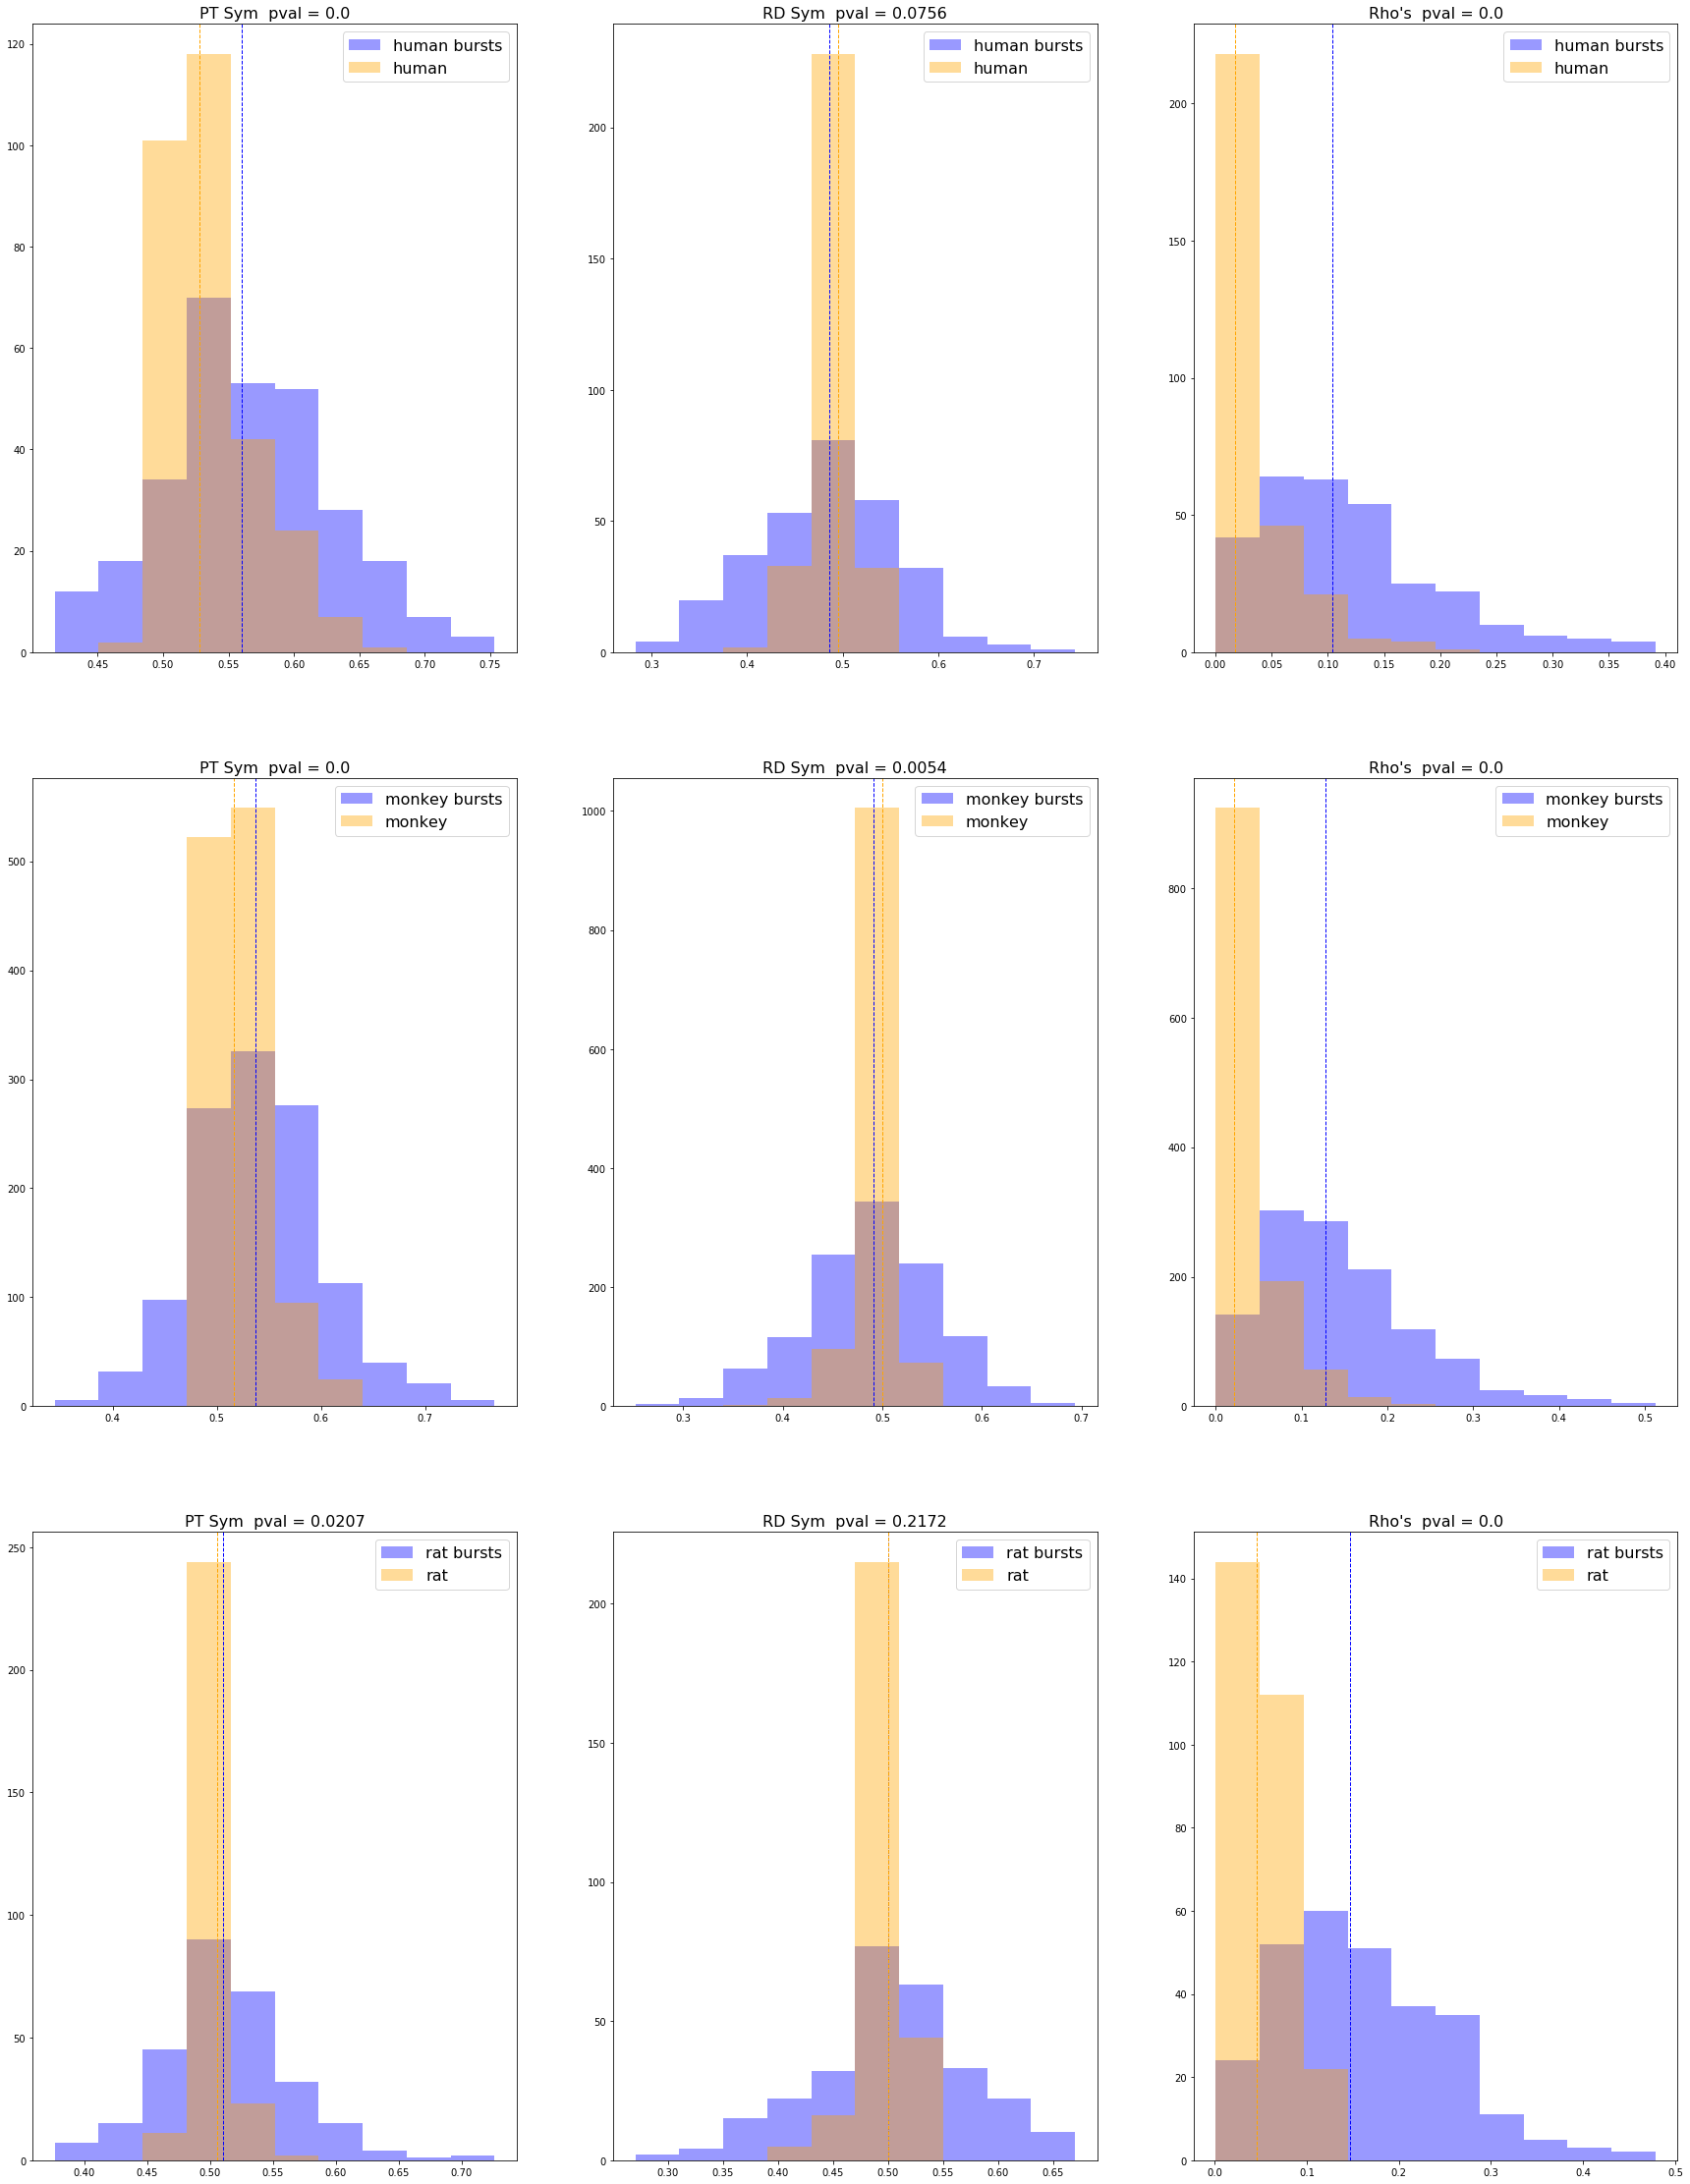

In [15]:
# get only the channels with a burst for comparing with their full channel distribution
burst_chs = {}
for key in datastruct: 

    burst_chs[key] = [ii 
                      for ii in range(len(burst_list[key])) 
                      if type(burst_list[key][ii]) == list 
                      if burst_list[key][ii][2]]



plt.figure(figsize=(30,40))
kwargs = dict(alpha=0.4)
jj = 0

for key in datastruct: 
        
    # pt symmetry
    jj = jj + 1
    plt.subplot(3,3,jj)

    burst_ptsym = [np.median(burst_list[key][ii][4]) 
              for ii in range(len(burst_list[key])) 
              if type(burst_list[key][ii]) == list
              if burst_list[key][ii][4]]

    burst_ptsym_fullch = [features_df[key]['ptsym'][burst_chs[key][ii]]
                     for ii in range(len(burst_chs[key]))]
        
    bins=np.histogram(np.hstack((burst_ptsym,burst_ptsym_fullch)), bins=10)[1]
    
    plt.hist(burst_ptsym, color='blue', bins=bins, label=(key + ' bursts'), **kwargs)
    plt.hist(burst_ptsym_fullch, color='orange', bins=bins, label=key, **kwargs)
    plt.axvline(np.nanmedian(burst_ptsym), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(burst_ptsym_fullch), color='orange', linestyle='dashed', linewidth=1)

    Uval, pval = stats.mannwhitneyu(burst_ptsym, 
                                 burst_ptsym_fullch, 
                                 use_continuity=True, alternative=None)

    plt.title('PT Sym  ' + 'pval = ' + str(round(pval,4)), size=16)
    plt.legend(fontsize=16)
    
    # Rho values
    jj = jj + 1
    plt.subplot(3,3,jj)
    burst_rdsym = [np.median(burst_list[key][ii][3]) 
              for ii in range(len(burst_list[key])) 
              if type(burst_list[key][ii]) == list
              if burst_list[key][ii][3]]

    burst_rdsym_fullch = [features_df[key]['rdsym'][burst_chs[key][ii]]
                     for ii in range(len(burst_chs[key]))]
    
    bins=np.histogram(np.hstack((burst_rdsym,burst_rdsym_fullch)), bins=10)[1]
    
    plt.hist(burst_rdsym, color='blue', bins=bins, label=(key + ' bursts'), **kwargs)
    plt.hist(burst_rdsym_fullch, color='orange', bins=bins, label=key, **kwargs)
    plt.axvline(np.nanmedian(burst_rdsym), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(burst_rdsym_fullch), color='orange', linestyle='dashed', linewidth=1)

    Uval, pval = stats.mannwhitneyu(burst_rdsym, 
                                 burst_rdsym_fullch, 
                                 use_continuity=True, alternative=None)

    plt.title('RD Sym  ' + 'pval = ' + str(round(pval,4)), size=16)
    plt.legend(fontsize=16)
    
    # Rho values 
    jj = jj + 1
    plt.subplot(3,3,jj)
        
    burst_rhos = [burst_rhos_dict[key][ii] 
                  for ii in range(len(burst_rhos_dict[key])) 
                  if str(burst_rhos_dict[key][ii]) != 'nan']
    
    burst_rhos_fullch = [features_df[key]['pac_rhos'][burst_chs[key][ii]]
                         for ii in range(len(burst_chs[key]))
                         if str(features_df[key]['pac_rhos'][burst_chs[key][ii]]) != 'nan']
 
    bins=np.histogram(np.hstack((burst_rhos,burst_rhos_fullch)), bins=10)[1]

    plt.hist(burst_rhos, color='blue', bins=bins, label=(key + ' bursts'), **kwargs)
    plt.hist(burst_rhos_fullch, color='orange', bins=bins, label=key, **kwargs)
    plt.axvline(np.nanmedian(burst_rhos), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(burst_rhos_fullch), color='orange', linestyle='dashed', linewidth=1)
    
    Uval, pval = stats.mannwhitneyu(burst_rhos, 
                                 burst_rhos_fullch, 
                                 use_continuity=True, alternative=None)
    
    plt.title('Rho\'s  ' + 'pval = ' + str(round(pval,4)), size=16)
    plt.legend(fontsize=16)

# 7. Low Gamma PAC descriptives

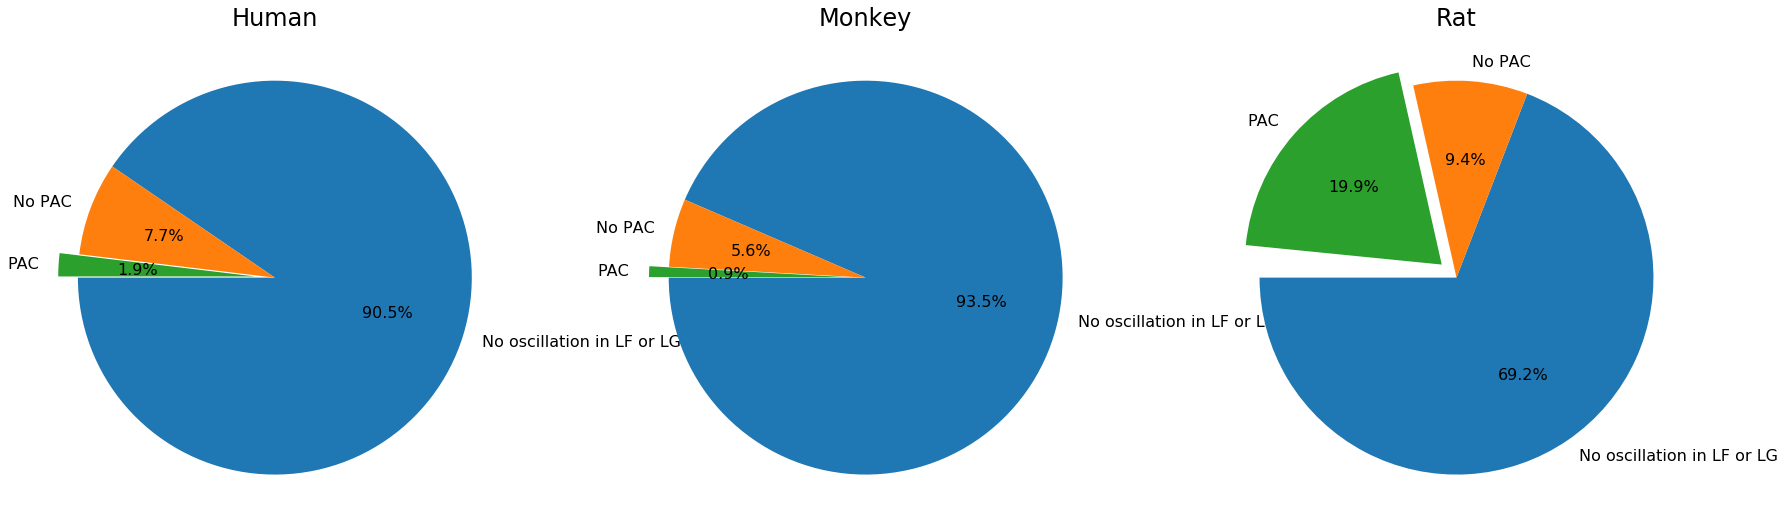

In [199]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation in LF or LG', 'No PAC', 'PAC'
sizes = [[1 - (len(features_df['human'][(~np.isnan(features_df['human']['CF'])) &
                                         (~np.isnan(features_df['human']['LG_CF']))]) / len(features_df['human'])),
         len(features_df['human'][features_df['human']['LG_pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['LG_pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (len(features_df['monkey'][(~np.isnan(features_df['monkey']['CF'])) &
                                         (~np.isnan(features_df['monkey']['LG_CF']))]) / len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (len(features_df['rat'][(~np.isnan(features_df['rat']['CF'])) &
                                      (~np.isnan(features_df['rat']['LG_CF']))]) / len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)

# 7.1 Stacked bar instead of pie chart

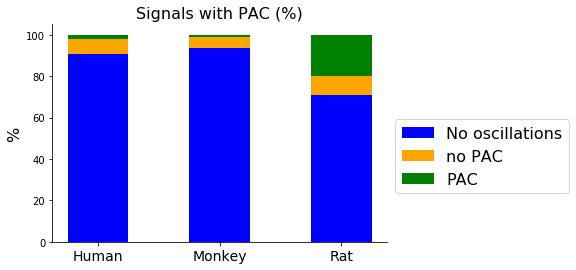

In [16]:
fig, ax = plt.subplots()
idx = np.arange(len(datastruct))
count = 0
width = 0.5
for key in datastruct: 
    
    no_osc =  len(features_df[key][features_df[key]['LG_pac_presence'] == np.int64]) / len(features_df[key]) * 100
    no_pac =  len(features_df[key][features_df[key]['LG_pac_presence']==0]) / len(features_df[key]) * 100
    yes_pac = len(features_df[key][features_df[key]['LG_pac_presence']==1]) / len(features_df[key]) * 100
    
    p1 = plt.bar(count+0.5, no_osc, width, color='blue', )
    p2 = plt.bar(count+0.5, no_pac, width,
                 bottom=no_osc, color='orange')
    p3 = plt.bar(count+0.5, yes_pac, width,
                 bottom=no_osc + no_pac, color='green')    
    
    count = count + 1
    
plt.ylabel('%', size=16)
plt.title('Signals with PAC (%)', size=16)
plt.xticks(idx +.5, ('Human', 'Monkey', 'Rat'), size=14)
plt.legend(['No oscillations', 'no PAC', 'PAC'], bbox_to_anchor=(1, .6), fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()    

# 8. Differences between LG and HG PAC in predicting Rho value 

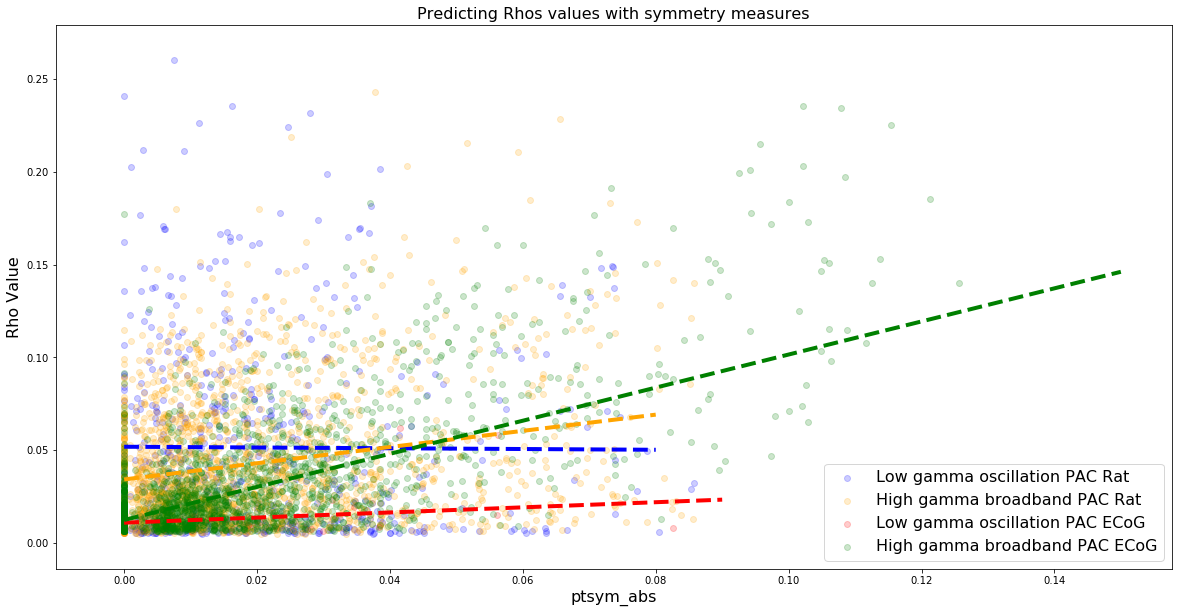

LG rat R^2: 0.284
LG rat pval: 0.0
HG rat R^2: 0.444
HG rat pval: 0.0
LG ECoG R^2: 0.408
LG ECoG pval: 0.0
HG ECoG R^2: 0.67
HG ECoG pval: 0.0


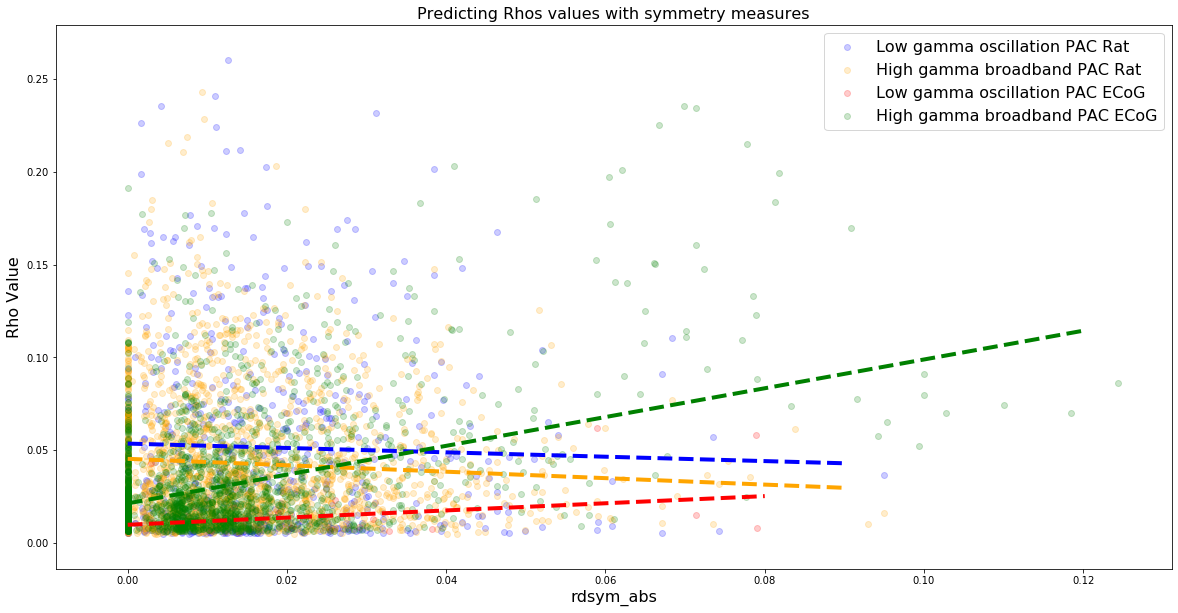

LG rat R^2: 0.305
LG rat pval: 0.0
HG rat R^2: 0.314
HG rat pval: 0.0
LG ECoG R^2: 0.46
LG ECoG pval: 0.0
HG ECoG R^2: 0.439
HG ECoG pval: 0.0


C:\Users\jaapv\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


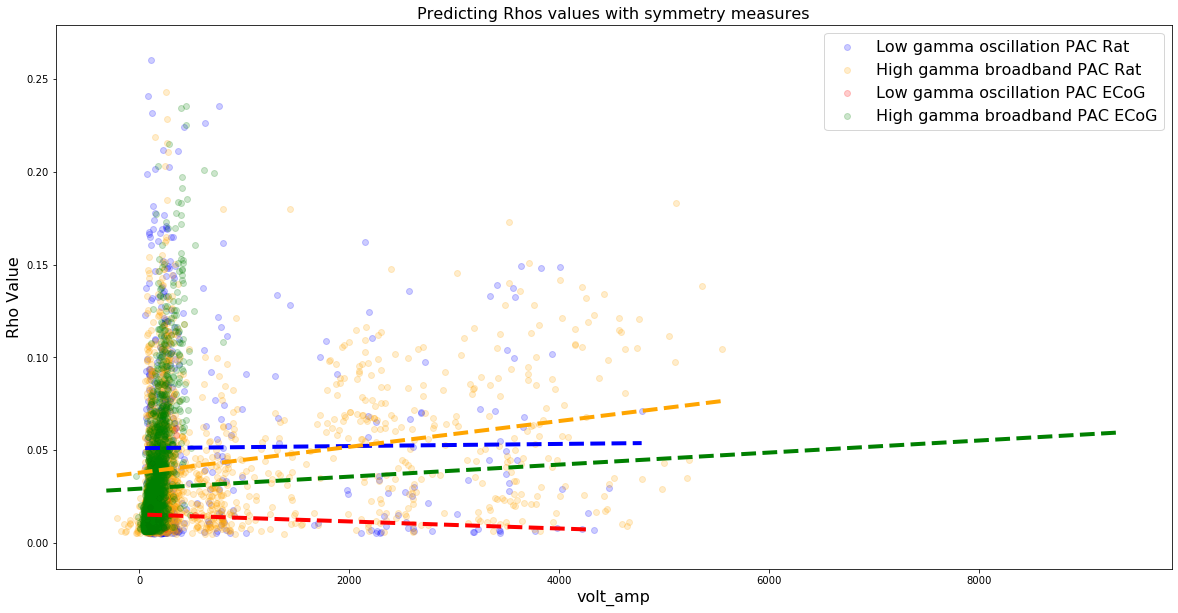

LG rat R^2: 0.158
LG rat pval: 0.0
HG rat R^2: 0.287
HG rat pval: 0.0
LG ECoG R^2: 0.169
LG ECoG pval: 0.003
HG ECoG R^2: 0.203
HG ECoG pval: 0.0


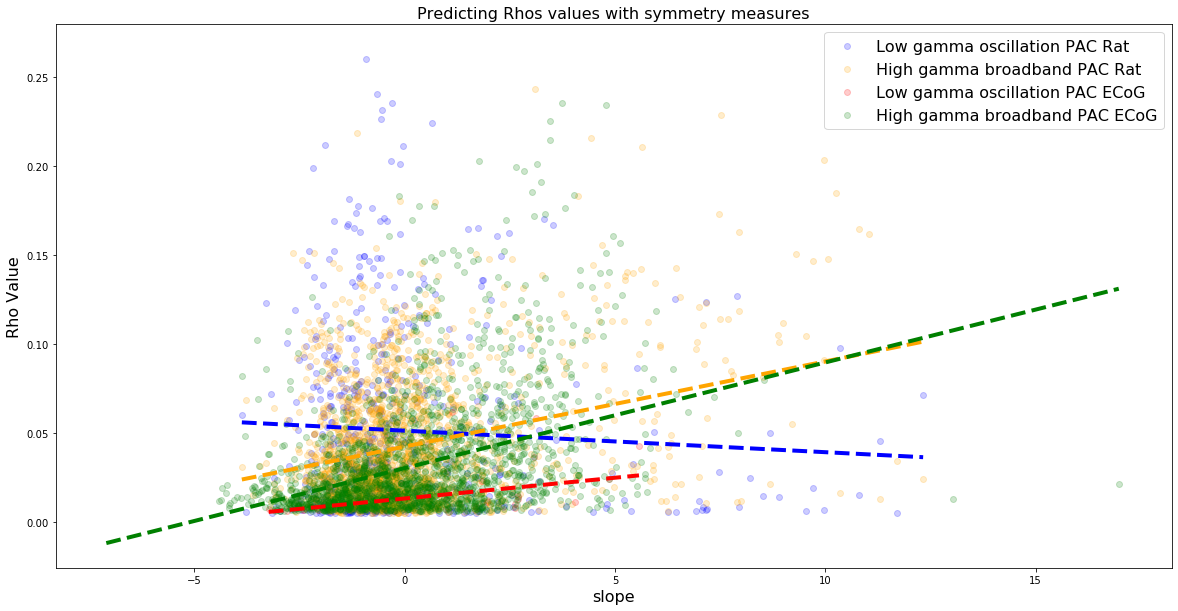

LG rat R^2: 0.005
LG rat pval: 0.091
HG rat R^2: 0.041
HG rat pval: 0.0
LG ECoG R^2: 0.108
LG ECoG pval: 0.021
HG ECoG R^2: 0.116
HG ECoG pval: 0.0


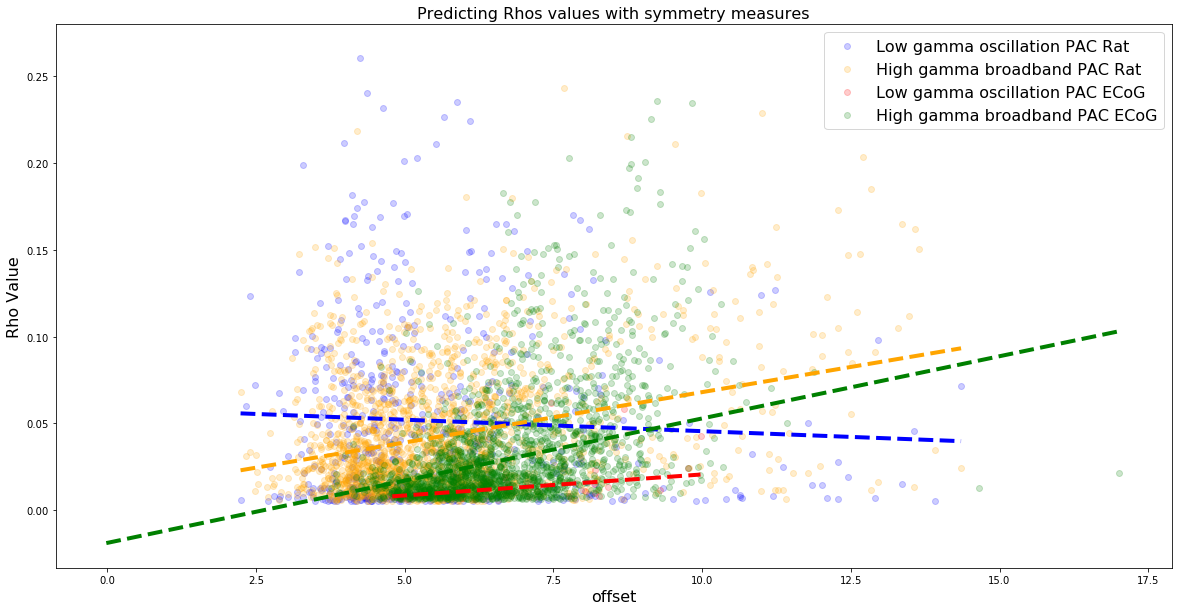

LG rat R^2: 0.43
LG rat pval: 0.0
HG rat R^2: 0.636
HG rat pval: 0.0
LG ECoG R^2: 0.613
LG ECoG pval: 0.0
HG ECoG R^2: 0.552
HG ECoG pval: 0.0


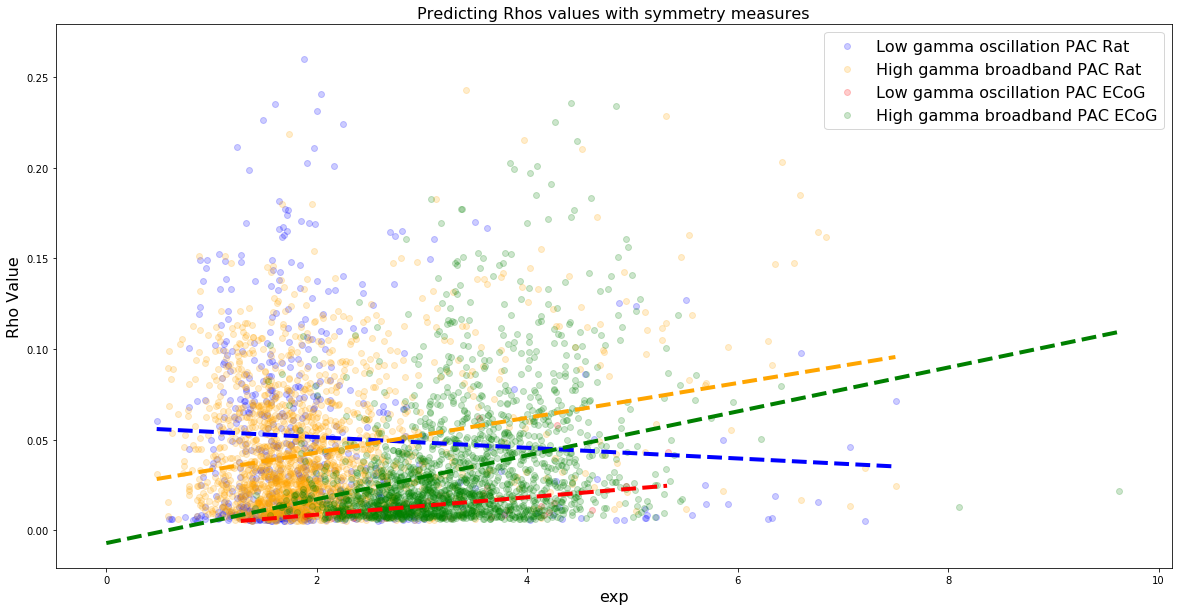

LG rat R^2: 0.369
LG rat pval: 0.0
HG rat R^2: 0.598
HG rat pval: 0.0
LG ECoG R^2: 0.64
LG ECoG pval: 0.0
HG ECoG R^2: 0.552
HG ECoG pval: 0.0


In [200]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

LG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'].values, 
         features_df['human'][features_df['human']['LG_pac_presence']==1]['LG_pac_rhos'].values).reshape(-1,1)
HG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values, 
         features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values).reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'ptsym_abs', 'rdsym_abs']
"""

feature = ['ptsym_abs', 'rdsym_abs', 'volt_amp','slope','offset', 'exp']

for ii in range(len(feature)):
    
    # reshape other feature
    LG_feature_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]].values.reshape(-1,1)
    HG_feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]].values.reshape(-1,1)

    LG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature[ii]].values,
                                  features_df['human'][features_df['human']['LG_pac_presence']==1][feature[ii]].values).reshape(-1,1)

    HG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]].values,
                                  features_df['human'][features_df['human']['pac_presence']==1][feature[ii]].values).reshape(-1,1)

    plt.figure(figsize=(20,10))

    # Rat LG scatter
    plt.scatter(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
               color='blue', alpha =.2, label='Low gamma oscillation PAC Rat')

    # Rat HG scatter
    plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
               color='orange', alpha =.2, label='High gamma broadband PAC Rat')

    # Monkey LG scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'],
               color='red', alpha =.2, label='Low gamma oscillation PAC ECoG')

    # Monkey HG scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
               color='green', alpha =.2, label='High gamma broadband PAC ECoG')


    # Rat regression
    reg1 = linear_model.LinearRegression()
    reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
    xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

    # Rat regression
    reg2 = linear_model.LinearRegression()
    reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
    xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

    # monkey regression
    reg3 = linear_model.LinearRegression()
    reg3.fit(LG_feature_ecog, LG_pac_rhos_ecog)
    xs = np.arange(min(LG_feature_ecog), max(LG_feature_ecog),0.01)
    ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='red', linewidth=4, alpha=1)

    # monkey regression
    reg4 = linear_model.LinearRegression()
    reg4.fit(HG_feature_ecog, HG_pac_rhos_ecog)
    xs = np.arange(min(HG_feature_ecog), max(HG_feature_ecog),0.01)
    ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)


    # 
    plt.title('Predicting Rhos values with symmetry measures', fontsize=16)
    plt.xlabel(feature[ii], fontsize=16)
    plt.ylabel('Rho Value', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    

    reg_LG_rat = OLS(LG_pac_rhos_rat, LG_feature_rat).fit()
    reg_HG_rat = OLS(HG_pac_rhos_rat, HG_feature_rat).fit()
    
    reg_LG_ecog = OLS(LG_pac_rhos_ecog, LG_feature_ecog).fit() 
    reg_HG_ecog = OLS(HG_pac_rhos_ecog, HG_feature_ecog).fit()


    print('LG rat R^2: ' +  str(round(reg_LG_rat.rsquared,3)))
    print('LG rat pval: ' +  str(round(reg_LG_rat.pvalues[0],3)))

    print('HG rat R^2: ' +  str(round(reg_HG_rat.rsquared,3)))
    print('HG rat pval: ' +  str(round(reg_HG_rat.pvalues[0],3)))

    print('LG ECoG R^2: ' +  str(round(reg_LG_ecog.rsquared,3)))
    print('LG ECoG pval: ' +  str(round(reg_LG_ecog.pvalues[0],3)))
    
    print('HG ECoG R^2: ' +  str(round(reg_HG_ecog.rsquared,3)))
    print('HG ECoG pval: ' +  str(round(reg_HG_ecog.pvalues[0],3)))


# 8.1 Regressions on Rat Dual Oscillator & Broadband PAC

LG rat R^2: PT Symmetry 0.284
LG rat pval: PT Symmetry 0.0
HG rat R^2: PT Symmetry 0.444
HG rat pval: PT Symmetry 0.0
LG rat R^2: RD Symmetry 0.305
LG rat pval: RD Symmetry 0.0
HG rat R^2: RD Symmetry 0.314
HG rat pval: RD Symmetry 0.0
LG rat R^2: Slope 0.005
LG rat pval: Slope 0.091
HG rat R^2: Slope 0.041
HG rat pval: Slope 0.0
LG rat R^2: Voltage Amplitude 0.158
LG rat pval: Voltage Amplitude 0.0
HG rat R^2: Voltage Amplitude 0.287
HG rat pval: Voltage Amplitude 0.0


C:\Users\jaapv\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


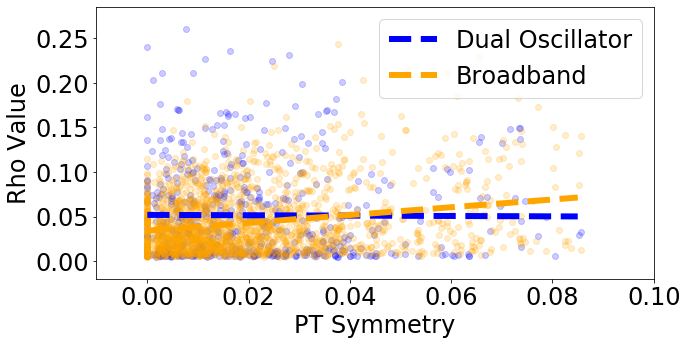

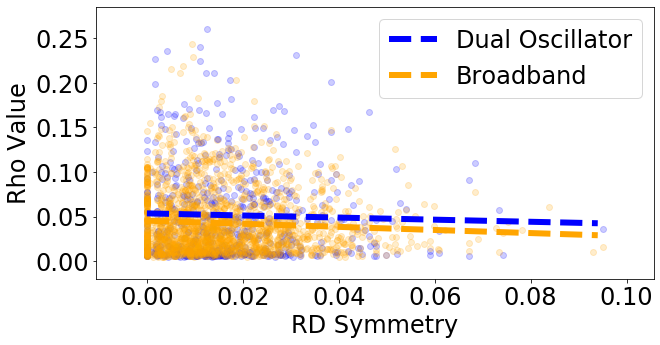

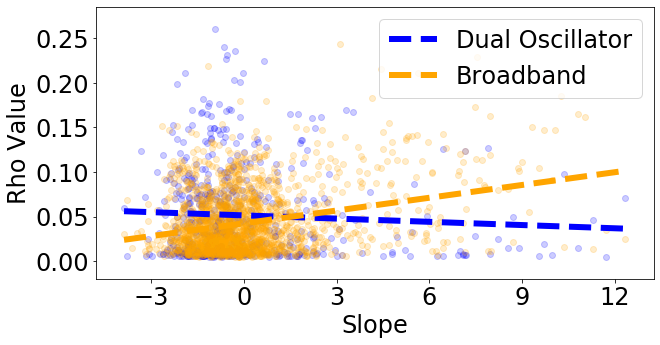

C:\Users\jaapv\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


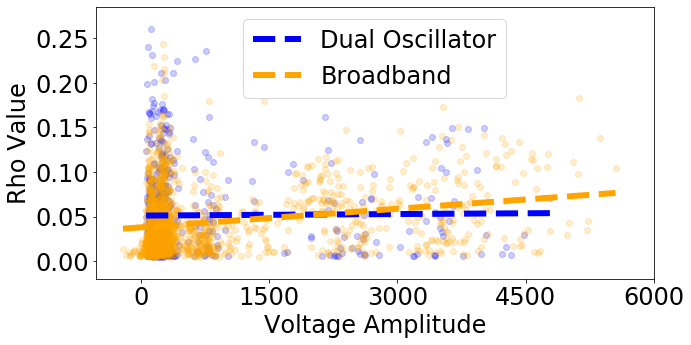

In [234]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)



"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'ptsym_abs', 'rdsym_abs']
"""

feature = ['ptsym_abs', 'rdsym_abs', 'slope', 'volt_amp']
feature_name = ['PT Symmetry', 'RD Symmetry', 'Slope', 'Voltage Amplitude']
ticklist = [[0, 0.02, 0.04, 0.06, 0.08,.1],[0, 0.02, 0.04, 0.06, 0.08, 0.1],
            [-3, 0, 3, 6, 9, 12], [0, 1500, 3000, 4500, 6000]]


for ii in range(len(feature)):
    
    # reshape other feature
    LG_feature_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]].values.reshape(-1,1)
    HG_feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]].values.reshape(-1,1)
    
    plt.figure(figsize=(10,5))
    

    # Rat LG scatter
    plt.scatter(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
               color='blue', alpha =.2, label='Low gamma oscillation PAC Rat')

    # Rat HG scatter
    plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
               color='orange', alpha =.2, label='High gamma broadband PAC Rat')


    # Rat LG regression
    reg1 = linear_model.LinearRegression()
    reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
    xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.001)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=6, alpha=1)

    # Rat HG regression
    reg2 = linear_model.LinearRegression()
    reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
    xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.001)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='orange', linewidth=6, alpha=1)


#     # plot parameters
#     #plt.title('Predicting Rhos values with symmetry measures', fontsize=24)
#     plt.xlabel(feature_name[ii], fontsize=24)
#     if ii == 0 or ii == 2: 
#         plt.ylabel('Rho Value', fontsize=24)
#     #plt.legend(['Low Gamma Oscillation', 'High Gamma Broadband'], fontsize=24)
#     plt.xticks(size=16)
#     plt.yticks(size=16)
#     #plt.show()
    
    plt.xlabel(feature_name[ii], fontsize=24)
    plt.ylabel('Rho Value', fontsize=24)
    plt.xticks(ticklist[ii],size=24)
    plt.yticks(size=24)
    plt.legend(['Dual Oscillator', 'Broadband'], fontsize=24)

    
    reg_LG_rat = OLS(LG_pac_rhos_rat, LG_feature_rat).fit()
    reg_HG_rat = OLS(HG_pac_rhos_rat, HG_feature_rat).fit()
    
    print('LG rat R^2: ' + feature_name[ii] + ' ' +  str(round(reg_LG_rat.rsquared,3)))
    print('LG rat pval: ' + feature_name[ii] + ' ' +  str(round(reg_LG_rat.pvalues[0],3)))

    print('HG rat R^2: ' + feature_name[ii] + ' ' +  str(round(reg_HG_rat.rsquared,3)))
    print('HG rat pval: ' + feature_name[ii] + ' ' +  str(round(reg_HG_rat.pvalues[0],3)))


# 9. Showing nested oscillations in short timeseries (for discussion)

In [233]:
freq_range = [4, 48] # for peak detection
bw_lims = [2, 6]
max_n_peaks = 5

key = 'human'

# set range of the band 
amplitude_providing_band = [80, 250]

for ii in range(0,10):
    
    if type(burst_list[key][ii]) == list:
        
        if burst_list[key][ii][2]:

            # define phase providing band
            CF = features_df[key]['CF'][ii]
            BW = features_df[key]['BW'][ii]


            # phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
            phase_providing_band= [(CF - (BW/2))-1,  (CF + (BW/2))+1]

            start_sample = burst_list[key][ii][0]
            end_sample = burst_list[key][ii][1]

            signal, fs = get_signal(datastruct, features_df, key, ii) 
            signal = signal[start_sample:end_sample]
            # data = datastruct[subj][ch][ep][start_sample:end_sample]
            # data = datastruct[subj][day][ch][ep][start_sample:end_sample]

            # use butter bandpass filter to extract this frequency range
            phase_data = pacf.butter_bandpass_filter(signal, phase_providing_band[0], phase_providing_band[1], fs);
            phase_data_hilbert = hilbert(phase_data);
            phase_data_angle = np.angle(phase_data_hilbert);
            
            # use butter bandpass filter to extract this frequency range
            amp_data = pacf.butter_bandpass_filter(signal, amplitude_providing_band[0], amplitude_providing_band[1], fs);
            amp_data_hilbert = hilbert(amp_data);
            amp_data_abs = abs(amp_data_hilbert);
            

            # plot signal
            # plt.figure(figsize=(30,30))
            fig = plt.figure(figsize=(30,30))
            gs = fig.add_gridspec(4, 3)
            
            # ax1: signal plot
            f_ax1 = fig.add_subplot(gs[0, :])
            plt.plot(signal - np.mean(signal),label= 'Raw Signal', color='black', alpha=.6)
            plt.plot(phase_data,
                     label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0]-1, phase_providing_band[1]+1),
                     linewidth=3, alpha=.6)
            plt.plot(amp_data,label= 'High Gamma [80-250 Hz]',
                     linewidth=3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
            plt.title('Plot of burst data with strong oscillation', size=24)
            plt.axis('off')
            
            # ax2: phase and amplitude plot
            f_ax2 = fig.add_subplot(gs[1, :])
            plt.plot(signal - np.mean(signal),label= 'Raw Signal', color='black', alpha=.6)
            plt.plot((phase_data_angle*np.mean(burst_list[key][ii][2])/2),
                     label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0]-1, phase_providing_band[1]+1),
                     linewidth=3, alpha=.6)
            plt.plot(amp_data_abs,label= 'High Gamma [80-250 Hz]',
                     linewidth=3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
            plt.title('Phase and amplitude on raw signal', size=24)
            plt.axis('off')
            
            # ax3: Amplitude distribution
            f_ax3 = fig.add_subplot(gs[2,0])
            plt.hist(burst_list[key][ii][2], bins=8)
            plt.axvline(np.mean(burst_list[key][ii][2]), color='red', linestyle='dashed', linewidth=3)
            plt.title('Voltage Amplitude', size=24)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)

           
            # ax4: RD Symmetry
            f_ax4 = fig.add_subplot(gs[2,1])
            plt.hist(burst_list[key][ii][3],bins=8)
            plt.axvline(np.mean(burst_list[key][ii][3]), color='red', linestyle='dashed', linewidth=3)
            plt.title('RD symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            
            
            # ax5: PT Symmetry
            f_ax5 = fig.add_subplot(gs[2,2])
            plt.hist(burst_list[key][ii][4], bins=8)
            plt.axvline(np.mean(burst_list[key][ii][4]), color='red', linestyle='dashed', linewidth=3)
            plt.title('PT symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            #plt.show()
            
            
            # preprocessing circle plot
            bin_size = 5; 
            bins = range(-180,180+bin_size,bin_size); 
            bins = np.dot(bins, 0.0174532925);

            amps = [];

            #filling phase bins with amplitudes
            for x in range(len(bins)-1):
                # find the lower bound of the bin
                amps_above_lo_bound = np.where(phase_data_angle >= bins[x])[0];
                # find the higher bound of the bin
                amps_below_hi_bound = np.where(phase_data_angle < bins[x+1])[0];
                amps_below_hi_bound = set(amps_below_hi_bound);
                # select all samples that are within the range
                amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
                # find corresponding amplitudes for these samples
                amps_in_this_bin = amp_data_abs[amp_inds_in_this_bin];
                # calculate mean
                amps.append(np.mean(amps_in_this_bin));

            bins = bins[:len(bins)-1];

            #normalizing to make the effect more clear
            amps = (amps-np.mean(amps))/np.std(amps);

            
            # ax6: Circle correlation
            f_ax6 = fig.add_subplot(gs[3,0], projection='polar')
            plt.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
            plt.ylim([0,3])
            plt.title('Phase to which activity is locked', size=24);
            

            #calculate circle correlation
            rho, pval, r_2, standard_error = pacf.circle_corr(phase_data_angle, amp_data_abs)
            
            # use full data for PSD
            signal, fs = get_signal(datastruct, features_df, key, ii) 
            
            # compute frequency spectrum
            freq_mean, psd_mean = spectral.compute_spectrum(signal, fs, method='welch', avg_type='mean', nperseg=fs)
            # Initialize FOOOF model
            fm = FOOOF(peak_width_limits=bw_lims, background_mode='knee', max_n_peaks=max_n_peaks)
            # fit model
            fm.fit(freq_mean, psd_mean, freq_range) 

            # ax7: Circle correlation
            f_ax7 = fig.add_subplot(gs[3,1])
            plot_spectrum(fm.freqs, fm.power_spectrum, label='Original Power Spectrum', ax=f_ax7)
            plt.title('PSD of full channel', size=24)
            
            
            # ax8: Stats 
            f_ax8 = fig.add_subplot(gs[3,2])
            f_ax8.text(1,7, 'The Rho-value of PAC is:' + '     ' + str(round(rho,3)), fontsize=24)
            f_ax8.text(1,6, 'The p-value of PAC is:' + '         ' + str(round(pval,3)), fontsize=24)
            f_ax8.text(1,4, 'BW:          ' +  str(round(BW,3)), fontsize=24) 
            f_ax8.text(1,3, 'CF:           '  + str(round(CF,3)), fontsize=24) 
            f_ax8.text(1,1, 'ch/ii:        '  + str(ii), fontsize=24)
                       
            f_ax8.axis([0, 10, 0, 10])
        
            f_ax8.axis('off')
            plt.show()

NameError: name 'burst_list' is not defined

# 10. Spatial consistency of measured features (for discussion)

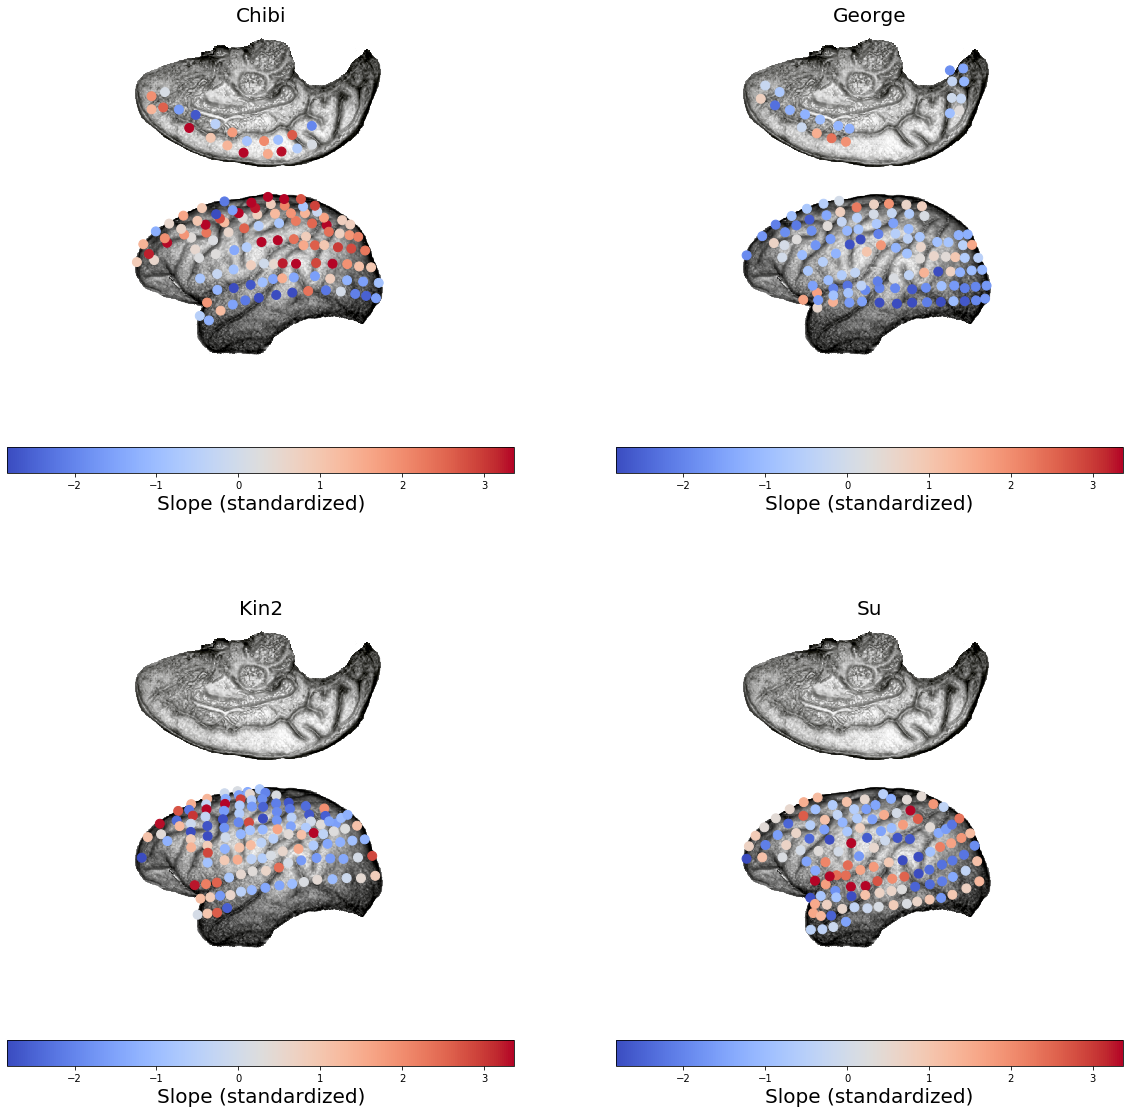

In [219]:
subjects = ['Chibi', 'George', 'Kin2', 'Su']
var = 'slope'

# set vmin and vmax as quantiles to deal with outliers and make consistent labeling
vmin = features_df['monkey'][var].quantile(0.05)
vmax = features_df['monkey'][var].quantile(0.95)

plt.figure(figsize=(20,20))
for subj in range(len(subjects)):  
    # go to specific map
    os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\neurotycho\anesthesia_sleep_task')    
    filemap = os.path.join(os.getcwd(), subjects[subj])   
    os.chdir(filemap)
    filename = glob.glob("*Map.mat")
    spatial_map = sio.loadmat(filename[0])

    var_values = [
            features_df['monkey'][(features_df['monkey']['subj'] == subj) & (features_df['monkey']['ch'] == ch)][var].median() 
            for ch in range(len(spatial_map['X']))
                ] 

    var_values = np.reshape(var_values, [len(var_values), 1]) 

    plt.subplot(2,2,subj+1)
    plt.imshow(spatial_map['I'])
    plt.scatter(spatial_map['X'], spatial_map['Y'], s=80, c=var_values, cmap='coolwarm',
                vmin=vmin, vmax=vmax)
    plt.title(subjects[subj], size=20)
    plt.axis('off')
    cbar= plt.colorbar(orientation='horizontal')
    cbar.set_label('Slope (standardized)', size=20)
